# IST 736:  Text Mining - Final Project                                                                                        Airline Review Tweets                                                                                              Sentiment & Topic Modeling
**Due date: 03/25/2023**  

## Authors: Meichan Huang, Ryan Trevo

## Purposes:
Construct Sentiment Analysis and Topic Modeling ML Algorithm
- Accurately and quickly identify customer sentiment 
- Identify core strengths and weaknesses in travel experience

## Models: 
Build two classification models in Python:
    Investigate Naïve Bayes and SVM
    Investigate model parameters
    Compare accuracy rates using cross validation techniques

Build two clustering models in Python:
    find clusters for all airlines for positive and negative
    find clusters by each airline and contrast/compare

In [3]:
#####################################################################################


In [39]:
#   IMPORT LIBRARIES:
# Importing libraries, methods, etc
import os
import re
import numpy as np
from   numpy import *
import pandas as pd
from   pprint import pprint

# NLTK
import nltk
from   nltk.corpus   import stopwords
from   nltk.tokenize import word_tokenize, RegexpTokenizer

# Word cloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Gensim libraries
import gensim
import gensim.corpora as corpora
from   gensim.utils import simple_preprocess
from   gensim.models import CoherenceModel
from   gensim.models.phrases import Phrases, Phraser
from   gensim.models import word2vec
from   gensim.test.utils import common_texts
from   gensim.sklearn_api import W2VTransformer

# Sklearn for classification tasks (MNB and SVM)
from sklearn.pipeline                import Pipeline
from sklearn.model_selection         import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes             import MultinomialNB
from sklearn.metrics                 import confusion_matrix
from sklearn.metrics                 import classification_report
from sklearn.model_selection         import cross_val_score
from sklearn.svm                     import LinearSVC
from sklearn.feature_extraction      import text   #extend the stopwords 

# SKlearn for topic modeling 
from sklearn.decomposition           import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection         import GridSearchCV
from pprint                          import pprint

# SpaCy
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')





#   IMPORT LIBRARIES: 
import numpy  as np
import pandas as pd

import sklearn
from   sklearn.model_selection         import train_test_split
from   sklearn.feature_extraction.text import CountVectorizer
from   sklearn.naive_bayes             import MultinomialNB
from   sklearn.metrics                 import accuracy_score
from   sklearn.metrics                 import precision_score
from   sklearn.metrics                 import recall_score
from   sklearn.svm                     import LinearSVC


In [5]:
#####################################################################################

In [6]:
#    LOAD DATA:
df0 = pd.read_csv('Tweets.csv')

#    INSPECT 
print(df0.head())
print("The shape of the dataframe (rows, columns):\t {}".format(df0.shape))
print(df0.dtypes)
print(df0.describe())



             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

In [7]:
#####################################################################################

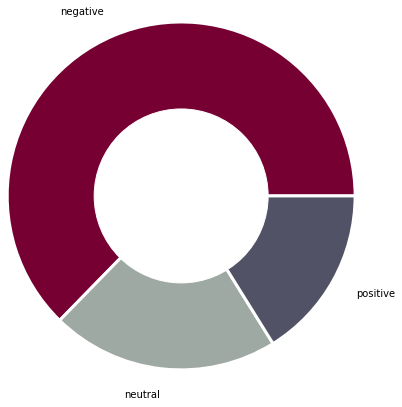

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


In [10]:
#   PLOT SENTIMENT FREQUENCY
#   MeichanL Create pie (donut) graph for sentiment

values = df0['airline_sentiment'].value_counts()
labels = ["negative", "neutral", "positive", ]

# Create a set of colors
colors = ['#770033', '#9fa9a3', '#525266', '#bf9000']

plt.pie(values, labels = labels, radius = 2, labeldistance = 1.15
        , wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors = colors);

my_circle = plt.Circle((0, 0), 1, color = 'white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()
print(values)


Text(0, 0.5, 'The number of reviews')

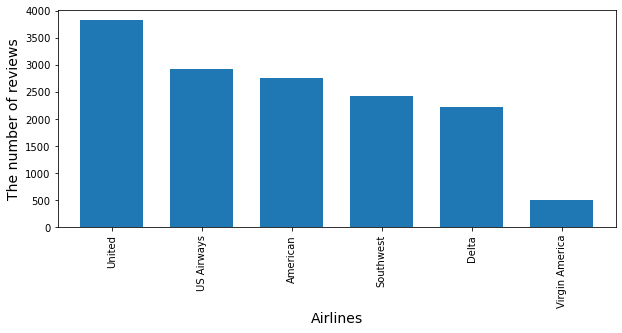

In [514]:
#descriptive analysis
reviewbyairline = pd.crosstab(index = df0['airline'], columns = 'count').sort_values('count' , ascending = False)
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 4
reviewbyairline['count'].plot(kind = 'bar', width = 0.7)
plt.xlabel("Airlines", fontsize = 14)
plt.ylabel("The number of reviews", fontsize = 14)

In [20]:
#################################################################################

In [12]:
#   CLEAN THE TWEETS:
df1 = df0.copy()
#   REMOVE URL'S:
df1['text_url'] = df1['text'].str.replace('http\S+|www.\S+', '', case=False)

#tokenize 
df1['word_token'] = df1['text_url'].apply(nltk.word_tokenize).tolist()

#   LEMMATIZE 
stemmer = nltk.stem.WordNetLemmatizer()
df1['token_stem'] = df1['word_token'].apply(lambda x: [stemmer.lemmatize(i) for i in x]) 


In [13]:
### The following codes are for creating the word cloud and the word cloud will use the column "token"

#lower case 
df1['token'] = df1['token_stem'].astype(str).str.lower()

def remove_punctuation(test_str):
# Using filter() and lambda function to filter out punctuation characters
  result = ''.join(filter(lambda x: x.isalpha() or x.isspace(), test_str))
  return result

df1['token'] = df1['token'].apply(lambda x: remove_punctuation(x)) 


In [251]:
#   SAVE UPDATED FILE:
df1.to_csv('tweets_cleaned.csv')
df1.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,text_url,word_token,token_stem,token
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),@VirginAmerica What @dhepburn said.,"[@, VirginAmerica, What, @, dhepburn, said, .]","[@, VirginAmerica, What, @, dhepburn, said, .]",virginamerica what dhepburn said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica plus you've added commercials t...,"[@, VirginAmerica, plus, you, 've, added, comm...","[@, VirginAmerica, plus, you, 've, added, comm...",virginamerica plus you ve added commercial to...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),@VirginAmerica I didn't today... Must mean I n...,"[@, VirginAmerica, I, did, n't, today, ..., Mu...","[@, VirginAmerica, I, did, n't, today, ..., Mu...",virginamerica i did nt today must mean i nee...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica it's really aggressive to blast...,"[@, VirginAmerica, it, 's, really, aggressive,...","[@, VirginAmerica, it, 's, really, aggressive,...",virginamerica it s really aggressive to blast...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),@VirginAmerica and it's a really big bad thing...,"[@, VirginAmerica, and, it, 's, a, really, big...","[@, VirginAmerica, and, it, 's, a, really, big...",virginamerica and it s a really big bad thing...


In [23]:
##############################################################################################################

In [16]:
#   REMOVE UNNECESSARY COLUMNS FOR MODELS
df2 = df1.copy()
df2 = df2.loc[:, ['airline_sentiment', 'negativereason', 'airline', 'text', 'token']]

df2.head()

# text, token, token_cleaned
X = df2['token'].values
y = df2['airline_sentiment'].values

#   SPLIT DATASET INTO 80% TRAIN AND 20% TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3168)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train[0])
print(y_train[0])
print(X_test[0])
print(y_test[0])



(11712,) (11712,) (2928,) (2928,)
 united thanks  seat made for a  year old and a broken tv   flightsyear  my last on your airline 
negative
 united i usually like flying with you guy but   fee to use my credit seems ridiculous  notcool  exhorbitantfees
negative


In [17]:
##############################################################################################################

In [18]:
#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt"]

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

In [19]:
##################################################################################

In [20]:
#   MODEL 1:  MULTINOMIAL NAIVE BAYES
########################################################################################
#   SET VARIABLES:
max_ngram            = 5

#   CREATE VECTORIZER:
vectorizer1 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 1500
                              , stop_words  = stopwords
                              , lowercase   = True
                              , ngram_range = (1, max_ngram))

#   VECTORIZE TRANSFOR:
X_train_vec1 = vectorizer1.fit_transform(X_train)
X_test_vec1  = vectorizer1.transform(X_test)

#   CREATE MODELS:
nb_clf = MultinomialNB()

#   TRAIN MODEL:
y_test_pred1 = nb_clf.fit(X_train_vec1, y_train).predict(X_test_vec1)

#   REPORT MODEL ACCURACY:
print('Model 1')
print('Accuracy:  ', accuracy_score(y_test, y_test_pred1))
print('Precision: ', precision_score(y_test, y_test_pred1, average = None))
print('Recall:    ', recall_score(y_test, y_test_pred1,    average = None))


#   Show  Confusion Matrix
print('\nConfusion Matrix\n', sklearn.metrics.confusion_matrix(y_test, y_test_pred1))

# Show classification result for CountVectorizer
target_names = ['negative','neutral','positive']
print(classification_report(y_test, y_test_pred1, target_names=target_names))

#   PRINT WORDS:
###################################################################################################################
#   Top 10 Negative
feature_ranks_neg1 = sorted(zip(nb_clf.feature_log_prob_[0], vectorizer1.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
negative10_mnb = feature_ranks_neg1[-10:]
print("Negative words with MNB CountVectorizer")
for i in range(0, len(negative10_mnb)):
    print(negative10_mnb[i])
print()



#   Top 10 Positive
feature_ranks_pos1 = sorted(zip(nb_clf.feature_log_prob_[2], vectorizer1.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
positive10_mnb = feature_ranks_pos1[-10:]
print("Positive words with MNB CountVectorizer")
for i in range(0, len(positive10_mnb)):
    print(positive10_mnb[i])
print()


Model 1
Accuracy:   0.76775956284153
Precision:  [0.80984556 0.61306533 0.71179039]
Recall:     [0.90948509 0.40666667 0.67494824]

Confusion Matrix
 [[1678  102   65]
 [ 289  244   67]
 [ 105   52  326]]
              precision    recall  f1-score   support

    negative       0.81      0.91      0.86      1845
     neutral       0.61      0.41      0.49       600
    positive       0.71      0.67      0.69       483

    accuracy                           0.77      2928
   macro avg       0.71      0.66      0.68      2928
weighted avg       0.75      0.77      0.75      2928

Negative words with MNB CountVectorizer
(-5.097050173626614, 'hold')
(-5.088699394409194, 'just')
(-5.086622550464355, 'plane')
(-5.047960563430091, 'help')
(-5.001168401923332, 'bag')
(-4.869305066399506, 'time')
(-4.81251771007773, 'service')
(-4.806228381170166, 'customer')
(-4.672892932506297, 'cancelled')
(-4.522865969862901, 'hour')

Positive words with MNB CountVectorizer
(-5.407520489923314, 'best')
(-5

In [21]:
#########################################################################

In [22]:
#   MODEL 2:  SVM
########################################################################################
#   SET VARIABLES:
max_ngram            = 3

#   CREATE VECTORIZER:
vectorizer2 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 2
                              , max_df      = 1500
                              , stop_words  = stopwords
                              , lowercase   = True
                              , ngram_range = (1, max_ngram))

#   VECTORIZE TRANSFOR:
X_train_vec2 = vectorizer2.fit_transform(X_train)
X_test_vec2  = vectorizer2.transform(X_test)
################################################################################################################
#   CREATE MODEL:
svm_clf = LinearSVC(C = 2)

#   TRAIN MODEL:
y_test_pred2 = svm_clf.fit(X_train_vec2, y_train).predict(X_test_vec2)

#   REPORT MODEL ACCURACY:
print('\nModel 2:  SVM')
print('Accuracy:  ', accuracy_score(y_test,  y_test_pred2))
print('Precision: ', precision_score(y_test, y_test_pred2, average = None))
print('Recall:    ', recall_score(y_test,    y_test_pred2, average = None))

#   Show  Confusion Matrix
print('\nConfusion Matrix\n', sklearn.metrics.confusion_matrix(y_test, y_test_pred2))

# Show classification result for CountVectorizer
target_names = ['negative','neutral','positive']
print(classification_report(y_test, y_test_pred2, target_names=target_names))

#   PRINT WORDS:
###################################################################################################################
#   Top 10 Negative
feature_ranks_neg2 = sorted(zip(svm_clf.coef_[0], vectorizer2.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
negative10_svm = feature_ranks_neg2[-10:]
print("Negative words using SVM CountVectorizer")
for i in range(0, len(negative10_svm)):
    print(negative10_svm[i])
print()

#   Top 10 Positive
feature_ranks_pos2 = sorted(zip(svm_clf.coef_[2], vectorizer2.get_feature_names()))
## get 10 features that are positive sentiment (they are at the top of the ranked list)
positive10_svm = feature_ranks_pos2[-10:]
print("Positive words using SVM CountVectorizer")
for i in range(0, len(positive10_svm)):
    print(positive10_svm[i])
print()



Model 2:  SVM
Accuracy:   0.7407786885245902
Precision:  [0.83369099 0.50918197 0.66666667]
Recall:     [0.84227642 0.50833333 0.64182195]

Confusion Matrix
 [[1554  214   77]
 [ 217  305   78]
 [  93   80  310]]
              precision    recall  f1-score   support

    negative       0.83      0.84      0.84      1845
     neutral       0.51      0.51      0.51       600
    positive       0.67      0.64      0.65       483

    accuracy                           0.74      2928
   macro avg       0.67      0.66      0.67      2928
weighted avg       0.74      0.74      0.74      2928

Negative words using SVM CountVectorizer
(1.584400184733459, 'worst')
(1.5866205258288693, 'ripped')
(1.6178583270760147, 'crashing')
(1.6318502387626577, 'strategy')
(1.7068764692611451, 'screwed')
(1.7653854795350634, 'ridiculous')
(1.7719759697377628, 'rescheduling flight')
(1.7978759449937338, 'really impressed')
(1.9145849313860692, 'courtesy')
(2.0620906793840863, 'supposed leave')

Positive word

In [23]:
#################################################################################################

In [33]:
#   MODEL 3:  TFIDF
########################################################################################

#   SET VARIABLES:
max_ngram            = 4

#   CREATE VECTORIZER:
vectorizer3 = TfidfVectorizer(encoding       = 'latin-1'
                              #, binary       = True   #Shouldn't this be binary = False because we don't want boolean 
                              , use_idf      = True
                              , min_df       = 5
                              , smooth_idf   = True
                              , sublinear_tf = True
                              , stop_words   = stopwords
                              #, lowercase    = True
                              , ngram_range  = (1, max_ngram)
                              , max_features = 2000
                            )

#   VECTORIZE TRANSFOR:
X_train_vec3 = vectorizer3.fit_transform(X_train)
X_test_vec3  = vectorizer3.transform(X_test)
################################################################################################################
#   CREATE MODEL:
#svm_clf = LinearSVC(C = 2)
svm_clf = LinearSVC(C = 1)

#   TRAIN MODEL:
y_test_pred3 = svm_clf.fit(X_train_vec3, y_train).predict(X_test_vec3)

#   REPORT MODEL ACCURACY:
print('\nModel 3')
print('Accuracy:  ', accuracy_score(y_test,  y_test_pred3))
print('Precision: ', precision_score(y_test, y_test_pred3, average = None))
print('Recall:    ', recall_score(y_test,    y_test_pred3, average = None))

#   Show  Confusion Matrix
print('\nConfusion Matrix\n', sklearn.metrics.confusion_matrix(y_test, y_test_pred3))

# Show classification result for this model
target_names = ['negative','neutral','positive']
print(classification_report(y_test, y_test_pred3, target_names=target_names))

#   PRINT WORDS:
###################################################################################################################
#   Top 10 Negative
feature_ranks_neg3 = sorted(zip(svm_clf.coef_[0], vectorizer3.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
negative10_tfidf = feature_ranks_neg3[-10:]
print("Negative words using SMV TFIDF")
for i in range(0, len(negative10_tfidf)):
    print(negative10_tfidf[i])
print()


#   Top 10 Positive
feature_ranks_pos3 = sorted(zip(svm_clf.coef_[2], vectorizer3.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
positive10_tfidf = feature_ranks_pos3[-10:]
print("Positive words using SMV TFIDF")
for i in range(0, len(positive10_tfidf)):
    print(positive10_tfidf[i])
print()



Model 3
Accuracy:   0.7708333333333334
Precision:  [0.82543641 0.58203125 0.73965937]
Recall:     [0.89701897 0.49666667 0.62939959]

Confusion Matrix
 [[1655  144   46]
 [ 241  298   61]
 [ 109   70  304]]
              precision    recall  f1-score   support

    negative       0.83      0.90      0.86      1845
     neutral       0.58      0.50      0.54       600
    positive       0.74      0.63      0.68       483

    accuracy                           0.77      2928
   macro avg       0.72      0.67      0.69      2928
weighted avg       0.76      0.77      0.76      2928

Negative words using SMV TFIDF
(1.9634927805882232, 'hour')
(1.9676548995364354, 'fail')
(1.9697056508556006, 'terrible')
(2.0538573283093347, 'hrs')
(2.0556393504575676, 'unacceptable')
(2.1105458078282657, 'lack')
(2.1167411128920666, 'ridiculous')
(2.225443708742921, 'alternate')
(2.277147215818386, 'error')
(2.98336856673892, 'worst')

Positive words using SMV TFIDF
(1.9551790813546477, 'wonderful')
(2.0

In [34]:
#   CROSS VALIDATION RESULTS (Why are we doing this?)


#   VECTORIZE DATA:
########################################################################################
X_train_vec1 = vectorizer1.fit_transform(X)
X_train_vec2 = vectorizer2.fit_transform(X)
X_train_vec3 = vectorizer3.fit_transform(X)


################################################################################################################
#   RUN CROSS VALIDATION
crossVal1a = cross_val_score(nb_clf,  X_train_vec1, y, cv = 10)   #MNB countvectorizer1
crossVal1b = cross_val_score(svm_clf, X_train_vec1, y, cv = 10)   #SVM countvectorizer1
crossVal2a = cross_val_score(nb_clf,  X_train_vec2, y, cv = 10)   #MNB countvectorizer2
crossVal2b = cross_val_score(svm_clf, X_train_vec2, y, cv = 10)   #SVM countvectorizer2
crossVal3a = cross_val_score(nb_clf,  X_train_vec3, y, cv = 10)   #MNB Tfidf
crossVal3b = cross_val_score(svm_clf, X_train_vec3, y, cv = 10)   #SVM Tfidf

#################################################################################################################
#   PRINT RESULTS:
print(mean(crossVal1a))
print(mean(crossVal1b))
print(mean(crossVal2a))
print(mean(crossVal2b))
print(mean(crossVal3a))
print(mean(crossVal3b))


0.7456284153005465
0.733811475409836
0.7450136612021858
0.7368169398907104
0.7361338797814208
0.7574453551912568


In [180]:
#################################################################################################################

In [175]:
print(sum(conf_mat1a))

14640


In [ ]:
##################################################################################################################

In [179]:
#If we decide to label the dataset as Negative and Non-negative? 

In [647]:
#################################################################################################################
#   REPEAT THE ABOVE USING TWO CATEGORIES:  NEGATIVE VS. NOT_NEGATIVE
#################################################################################################################
#   REMOVE UNNECESSARY COLUMNS FOR MODELS
df2 = df1.copy()
df2 = df2.loc[:, ['airline_sentiment', 'negativereason', 'airline', 'text', 'token']]

df2.head()

# text, token, token_cleaned
X = df2['token'].values
y = df2['airline_sentiment'].values
y[y!= 'negative'] = 'notNegative'

#   SPLIT DATASET INTO 80% TRAIN AND 20% TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3168)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#################################################################################################################

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt"]

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

(11712,) (11712,) (2928,) (2928,)


In [663]:
#   MODEL 1:  MULTINOMIAL NAIVE BAYES
########################################################################################
#   SET VARIABLES:
max_ngram = 5


#   CREATE VECTORIZER:
vectorizer1 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 1500
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram))

#   VECTORIZE TRANSFOR:
X_train_vec1 = vectorizer1.fit_transform(X_train)
X_test_vec1  = vectorizer1.transform(X_test)

#   CREATE MODELS:
nb_clf = MultinomialNB()

#   TRAIN MODEL:
y_test_pred1 = nb_clf.fit(X_train_vec1, y_train).predict(X_test_vec1)

#   REPORT MODEL ACCURACY:
print('Model 1')
print('Accuracy:  ', accuracy_score(y_test, y_test_pred1))
print('Precision: ', precision_score(y_test, y_test_pred1, average = None))
print('Recall:    ', recall_score(y_test, y_test_pred1, average = None))

#   Show  Confusion Matrix
print('\nConfusion Matrix\n', sklearn.metrics.confusion_matrix(y_test, y_test_pred1))


# Show classification result for CountVectorizer
target_names = ['negative','notNegative']
print(classification_report(y_test, y_test_pred1, target_names=target_names))

Model 1
Accuracy:   0.8118169398907104
Precision:  [0.8247992  0.78418803]
Recall:     [0.89051491 0.677747  ]

Confusion Matrix
 [[1643  202]
 [ 349  734]]
              precision    recall  f1-score   support

    negative       0.82      0.89      0.86      1845
 notNegative       0.78      0.68      0.73      1083

    accuracy                           0.81      2928
   macro avg       0.80      0.78      0.79      2928
weighted avg       0.81      0.81      0.81      2928



In [668]:
#   PRINT WORDS:
###################################################################################################################
#   Top 10 Negative
feature_ranks_neg1 = sorted(zip(nb_clf.feature_log_prob_[0], vectorizer1.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
negative10_mnb = feature_ranks_neg1[-10:]
print("Negative words with MNB CountVectorizer")
for i in range(0, len(negative10_mnb)):
     print(negative10_mnb[i])
print()

#   Top 10 non-negative
feature_ranks_pos1 = sorted(zip(nb_clf.feature_log_prob_[1], vectorizer1.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
positive10_mnb = feature_ranks_pos1[-10:]
print("Non-negative words with MNB CountVectorizer")
for i in range(0, len(positive10_mnb)):
    print(positive10_mnb[i])
print()

Negative words with MNB CountVectorizer
(-5.097050173626614, 'hold')
(-5.088699394409194, 'just')
(-5.086622550464355, 'plane')
(-5.047960563430091, 'help')
(-5.001168401923332, 'bag')
(-4.869305066399506, 'time')
(-4.81251771007773, 'service')
(-4.806228381170166, 'customer')
(-4.672892932506297, 'cancelled')
(-4.522865969862901, 'hour')

Non-negative words with MNB CountVectorizer
(-5.4783660431603645, 'love')
(-5.465627017382935, 'amp')
(-5.422276576509321, 'time')
(-5.3924236133596395, 'need')
(-5.335265199519691, 'service')
(-5.215016071368114, 'great')
(-5.195503257144533, 'help')
(-4.9335106708080625, 'just')
(-4.526807172448751, 'thank')
(-4.118047168443734, 'thanks')



In [677]:
#   MODEL 2:  SVM
########################################################################################
#   SET VARIABLES:
max_ngram = 3

#   CREATE VECTORIZER:
vectorizer2 = CountVectorizer(encoding = 'latin-1'
                              , binary = False
                              , min_df = 2
                              , max_df = 1500
                              , stop_words = stopwords
                              , lowercase = True
                              , ngram_range = (1, max_ngram))

#   VECTORIZE TRANSFOR:
X_train_vec2 = vectorizer2.fit_transform(X_train)
X_test_vec2  = vectorizer2.transform(X_test)
################################################################################################################
#   CREATE MODEL:
svm_clf = LinearSVC(C = 1)

#   TRAIN MODEL:
y_test_pred2 = svm_clf.fit(X_train_vec2, y_train).predict(X_test_vec2)

#   REPORT MODEL ACCURACY:
print('\nModel 2:  SVM')
print('Accuracy:  ', accuracy_score(y_test,  y_test_pred2))
print('Precision: ', precision_score(y_test, y_test_pred2, average = None))
print('Recall:    ', recall_score(y_test,    y_test_pred2, average = None))


#   Show  Confusion Matrix
print('\nConfusion Matrix\n', sklearn.metrics.confusion_matrix(y_test, y_test_pred2))


# Show classification result for CountVectorizer
target_names = ['negative','notNegative']
print(classification_report(y_test, y_test_pred2, target_names = target_names))


Model 2:  SVM
Accuracy:   0.796448087431694
Precision:  [0.84144341 0.72156506]
Recall:     [0.83414634 0.7322253 ]

Confusion Matrix
 [[1539  306]
 [ 290  793]]
              precision    recall  f1-score   support

    negative       0.84      0.83      0.84      1845
 notNegative       0.72      0.73      0.73      1083

    accuracy                           0.80      2928
   macro avg       0.78      0.78      0.78      2928
weighted avg       0.80      0.80      0.80      2928



In [678]:
#   PRINT WORDS:
###################################################################################################################
#   Top 10 Negative
feature_ranks_neg2 = sorted(zip(svm_clf.coef_[0], vectorizer2.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
negative10_svm = feature_ranks_neg2[-10:]
print("Negative words using SVM CountVectorizer")
for i in range(0, len(negative10_svm)):
    print(negative10_svm[i])
print()

##   Top 10 Positive
feature_ranks_pos2 = sorted(zip(svm_clf.coef_[0], vectorizer2.get_feature_names()))
### get 10 features that are positive sentiment (they are at the top of the ranked list)
positive10_svm = feature_ranks_pos2[0:10]
print("Non-negative words using SVM CountVectorizer")
for i in range(0, len(positive10_svm)):
    print(positive10_svm[i])
print()

Negative words using SVM CountVectorizer
(1.2658223966941053, 'time good')
(1.279404446769576, 'desk phone')
(1.280702471474646, 'imaginedragons')
(1.2834410783131815, 'kudos')
(1.28912808397903, 'cal')
(1.3031625024230902, 'lost voucher')
(1.3096729231824107, 'helpful told')
(1.3287527995271642, 'bag really')
(1.3921914849479458, 'ca wait')
(1.4422028569441325, 'connection flight')

Positive words using SVM CountVectorizer
(-1.563869630678956, 'supposed leave')
(-1.5419800792314906, 'courtesy')
(-1.4321087213995514, 'ridiculous')
(-1.407558185690004, 'screwed')
(-1.3883068313426121, 'worst')
(-1.3209097310070979, 'really impressed')
(-1.3109154097100348, 'lie')
(-1.303140048191917, 'confirmed flight')
(-1.3009555387078993, 'ripped')
(-1.2967653676616107, 'hell')



In [682]:
#   MODEL 3:  TFIDF
########################################################################################

#   SET VARIABLES:
max_ngram = 4

#   CREATE VECTORIZER:
vectorizer3 = TfidfVectorizer(encoding       = 'latin-1'
                              #, binary       = True   #Shouldn't this be binary = False because we don't want boolean 
                              , use_idf      = True
                              , min_df       = 5
                              , smooth_idf   = True
                              , sublinear_tf = True
                              , stop_words   = stopwords
                              #, lowercase    = True
                              , ngram_range  = (1, max_ngram)
                              , max_features = 2000
                            )

#   VECTORIZE TRANSFOR:
X_train_vec3 = vectorizer3.fit_transform(X_train)
X_test_vec3  = vectorizer3.transform(X_test)
################################################################################################################
#   CREATE MODEL:
svm_clf = LinearSVC(C = 2)
#svm_clf = LinearSVC(C = 1)

#   TRAIN MODEL:
y_test_pred3 = svm_clf.fit(X_train_vec3, y_train).predict(X_test_vec3)

#   REPORT MODEL ACCURACY:
print('\nModel 3')
print('Accuracy:  ', accuracy_score(y_test,  y_test_pred3))
print('Precision: ', precision_score(y_test, y_test_pred3, average = None))
print('Recall:    ', recall_score(y_test,    y_test_pred3, average = None))

#   Show  Confusion Matrix
print('\nConfusion Matrix\n', sklearn.metrics.confusion_matrix(y_test, y_test_pred3))

# Show classification result for this model
target_names = ['negative','notNegative']
print(classification_report(y_test, y_test_pred3, target_names=target_names))


Model 3
Accuracy:   0.8077185792349727
Precision:  [0.84132055 0.74761905]
Recall:     [0.85636856 0.72483841]

Confusion Matrix
 [[1580  265]
 [ 298  785]]
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      1845
 notNegative       0.75      0.72      0.74      1083

    accuracy                           0.81      2928
   macro avg       0.79      0.79      0.79      2928
weighted avg       0.81      0.81      0.81      2928



In [686]:
#   PRINT WORDS:
###################################################################################################################
#   Top 10 Negative
feature_ranks_neg3 = sorted(zip(svm_clf.coef_[0], vectorizer3.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
negative10_tfidf = feature_ranks_neg3[0:10]
print("Negative words using SMV TFIDF")
for i in range(0, len(negative10_tfidf)):
    print(negative10_tfidf[i])
print()

#   Top 10 Positive
feature_ranks_pos3 = sorted(zip(svm_clf.coef_[0], vectorizer3.get_feature_names()))
## get 10 features that are least relevant to "very negative" sentiment (they are at the top of the ranked list)
positive10_tfidf = feature_ranks_pos3[-10:]
print("Non-negative words using SMV TFIDF")
for i in range(0, len(positive10_tfidf)):
    print(positive10_tfidf[i])
print()

Negative words using SMV TFIDF
(-3.6719865860520176, 'worst')
(-2.870807396042356, 'alternate')
(-2.7988196272095145, 'error')
(-2.713096545047464, 'unacceptable')
(-2.593512260016257, 'ridiculous')
(-2.564308829072655, 'hrs')
(-2.511518519234866, 'fail')
(-2.499146111687393, 'lack')
(-2.4801100195741244, 'lie')
(-2.4550868050066486, 'miserable')

Non-negative words using SMV TFIDF
(1.9531115089899609, 'promo')
(1.9564732721978733, 'outstanding')
(1.9699890155721156, 'passbook')
(2.0089563919626445, 'thanks help')
(2.053727696886211, 'amazing')
(2.0715582668705794, 'kudos')
(2.0788645166182182, 'taken care')
(2.434728906261593, 'ca wait')
(2.509594780560725, 'imaginedragons')
(2.633207605589341, 'thank')



In [688]:
#   VECTORIZE DATA:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

########################################################################################
X_train_vec1 = vectorizer1.fit_transform(X)
X_train_vec2 = vectorizer2.fit_transform(X)
X_train_vec3 = vectorizer3.fit_transform(X)

#   CONVERT TO NEGATIVE AND NOTNEGATIVE
########################################################################################
y[y != 'negative'] = 'notNegative'

########################################################################################
#   RUN CROSS VALIDATION
y_pred1a = cross_val_predict(nb_clf, X_train_vec1, y, cv = 10)
y_pred1b = cross_val_predict(nb_clf, X_train_vec2, y, cv = 10)
y_pred1c = cross_val_predict(nb_clf, X_train_vec3, y, cv = 10)

y_pred2a = cross_val_predict(svm_clf, X_train_vec1, y, cv = 10)
y_pred2b = cross_val_predict(svm_clf, X_train_vec2, y, cv = 10)
y_pred2c = cross_val_predict(svm_clf, X_train_vec3, y, cv = 10)


#################################################################################################################
#   PRINT RESULTS:
target_names = ['negative','positive', 'neutral']
target_names = ['negative','notNegative']


print(classification_report(y, y_pred1a, target_names = target_names))
print(classification_report(y, y_pred1b, target_names = target_names))
print(classification_report(y, y_pred1c, target_names = target_names))
print(classification_report(y, y_pred2a, target_names = target_names))
print(classification_report(y, y_pred2b, target_names = target_names))
print(classification_report(y, y_pred2c, target_names = target_names))

              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      9178
 notNegative       0.75      0.67      0.71      5462

    accuracy                           0.79     14640
   macro avg       0.78      0.77      0.77     14640
weighted avg       0.79      0.79      0.79     14640

              precision    recall  f1-score   support

    negative       0.82      0.87      0.84      9178
 notNegative       0.75      0.67      0.71      5462

    accuracy                           0.80     14640
   macro avg       0.78      0.77      0.78     14640
weighted avg       0.79      0.80      0.79     14640

              precision    recall  f1-score   support

    negative       0.78      0.92      0.85      9178
 notNegative       0.81      0.57      0.67      5462

    accuracy                           0.79     14640
   macro avg       0.80      0.74      0.76     14640
weighted avg       0.79      0.79      0.78     14640

              preci

## Section 3: Topic Modeling 

In [49]:
#Filter for Positive data only with the token 
df_pos = df2[df2['airline_sentiment'].str.contains("positive")]


# Let's filter for 'negative' labels only:
df_neg= df2[df2['airline_sentiment'].str.contains("negative")]

# Converting that positive "token column" into a Python list:
data_pos = df_pos.token.tolist()

# Converting negative "token column" into a Python list:
data_neg = df_neg.token.tolist()

#The reason for such choice was because the URL was still a problem in the topic modeling, in topic 3, there was http_co 

#### Modeling positive topics

In [50]:
# Preprocessing using Gensim's "simple_preprocess" library
# this library lowercases, tokenizes, and performs 
# all other basic preprocesing to turn text into data
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# We crate one list per tweet, with all clean tokens
data_word_pos = list(sent_to_words(data_pos))

# let's confirm the output for 2 tweets 
print(data_word_pos[:2])

# We'll also check the length of our list of lists. It should equal the number of rows with text
# in the database:
print(len(data_word_pos))

[['virginamerica', 'plus', 'you', 've', 'added', 'commercial', 'to', 'the', 'experience', 'tacky'], ['virginamerica', 'yes', 'nearly', 'every', 'time', 'fly', 'vx', 'this', 'ear', 'worm', 'won', 'go', 'away']]
2363


In [51]:
# Building the bigram and trigram models using Gensim 
bigram_pos = Phrases(data_word_pos, min_count=5, threshold=50) 
trigram_pos = Phrases(bigram_pos[data_word_pos], threshold=50) 

# Creating variables with bigrams and trigrams using Phraser
bigram_mod = Phraser(bigram_pos)
trigram_mod = Phraser(trigram_pos)

print(bigram_mod[data_word_pos[10]])

['virginamerica', 'you', 'know', 'what', 'would', 'be', 'amazingly', 'awesome', 'bosfll', 'please', 'want', 'to', 'fly', 'with', 'only', 'you']


In [52]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# we will use the bigrams code above to create funtions that will process the entire corpus
#This chunk does not need to be redone for the negative comments 

# from nltk.corpus import stopwords and extend it
stop_words = nltk.corpus.stopwords.words("english")
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt"]
stop_words.extend(additional_stopwords)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Function to create bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Function to create trigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Function to lemmatize
# We use a library called 'spacy' (https://spacy.io/) for this
# To speeed up processing, we'll only lemmatize nouns, adjectives, verbs, and adverbs
# since these are the most important words for polarity (remember we are processing text
# deemed 'positive' in polarity)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [53]:
# After creating the functions, we start processing our text
# First, we remove stopwords and create a variable with the clean corpus
data_word_pos_nostops = remove_stopwords(data_word_pos)

# Now we use that cleaned corpus in 'data_words_nostops' to create 
data_word_pos_bigrams = make_bigrams(data_word_pos_nostops)

# We initialize spacy's 'en_core_web_sm' package for Website text (https://spacy.io/models/en)
#If we encounter error message, here is the solution: https://github.com/explosion/spaCy/issues/7453
nlp = en_core_web_sm.load()

# Finally, we extract our groups of words and lemmatize them
data_lemmatized_pos = lemmatization(data_word_pos_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_pos[:2])

[['add', 'commercial', 'experience', 'tacky'], ['nearly', 'time', 'fly', 'ear', 'worm', 'go', 'away']]


In [178]:
## pip install  https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [54]:
# Create Dictionary
id2word_pos = corpora.Dictionary(data_lemmatized_pos)

# Create Corpus
texts_pos = data_lemmatized_pos

# Term Document Frequency. "id2word" matches words with their IDs in the corpus
# "doc2bow" converts the corpus into a bag of words 
corpus_pos = [id2word_pos.doc2bow(text) for text in texts_pos]

# View frequency tuples: first index is the word and second is the frequency for that word
print(corpus_pos[:1])

# Printing the first token
print(id2word_pos[0])

# Human readable format of corpus (term-frequency)
[[(id2word_pos[id], freq) for id, freq in cp] for cp in corpus_pos[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1)]]
add


[[('add', 1), ('commercial', 1), ('experience', 1), ('tacky', 1)]]

In [55]:
# Build LDA model with 5 topics: 
# Avoiding future changes warning messages
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Parametize the model
# See details for parameters values: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [56]:
# Print keyword for the topics created 
# the number besides the topic shows the probability score for that topic within the cluster
pprint(lda_model_pos.print_topics())
doc_lda_pos = lda_model_pos[corpus_pos]

[(0,
  '0.223*"thank" + 0.030*"make" + 0.022*"appreciate" + 0.021*"help" + '
  '0.021*"guy" + 0.019*"much" + 0.015*"well" + 0.012*"amazing" + 0.011*"know" '
  '+ 0.011*"home"'),
 (1,
  '0.086*"flight" + 0.050*"great" + 0.044*"good" + 0.021*"work" + 0.019*"crew" '
  '+ 0.018*"plane" + 0.015*"service" + 0.015*"keep" + 0.014*"back" + '
  '0.013*"day"'),
 (2,
  '0.041*"awesome" + 0.022*"check" + 0.022*"really" + 0.016*"weather" + '
  '0.015*"problem" + 0.014*"ticket" + 0.013*"travel" + 0.011*"happy" + '
  '0.010*"last" + 0.010*"air"'),
 (3,
  '0.042*"love" + 0.032*"fly" + 0.032*"time" + 0.028*"aa" + 0.027*"today" + '
  '0.026*"airline" + 0.021*"new" + 0.021*"see" + 0.018*"hope" + 0.015*"take"'),
 (4,
  '0.024*"nice" + 0.018*"still" + 0.015*"warm" + 0.015*"people" + 0.014*"next" '
  '+ 0.014*"book" + 0.012*"say" + 0.012*"phone" + 0.012*"lot" + 0.011*"do"')]


In [57]:
# Compute Perplexity for positive topics (5 topics)
print('\nPerplexity: ', lda_model_pos.log_perplexity(corpus_pos))  # More than one model is needed for this measure. 
#The model with the lowest perplexity is generally considered the “best”.
# Compute Coherence Score. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
# A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model_lda_pos = CoherenceModel(model=lda_model_pos, texts=data_lemmatized_pos, dictionary=id2word_pos, coherence='c_v')
coherence_lda_pos = coherence_model_lda_pos.get_coherence()
print('\nCoherence Score: ', coherence_lda_pos)


Perplexity:  -7.596115684602596

Coherence Score:  0.39420513956465686


In [222]:
from __future__ import division

# Visualize the topics using pyLDAvis
# Save the visualization as an html file
pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim.prepare(lda_model_pos, corpus_pos, id2word_pos,  mds='mmds')
pyLDAvis.display(vis1, template_type='notebook') 


pyLDAvis.save_html(vis1,'LDA_viz_pos_5.html')

In [691]:
vis1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.317910 -0.042927       1        1  29.589174
1      0.088521  0.291768       2        1  27.956983
3     -0.247792 -0.160699       3        1  17.727774
2     -0.192501  0.130128       4        1  13.078246
4      0.033862 -0.218270       5        1  11.647822, topic_info=       Term        Freq       Total Category  logprob  loglift
40    thank  990.000000  990.000000  Default  30.0000  30.0000
47   flight  362.000000  362.000000  Default  29.0000  29.0000
28    great  210.000000  210.000000  Default  28.0000  28.0000
15     good  185.000000  185.000000  Default  27.0000  27.0000
58     love  114.000000  114.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
451  minute   10.980172   11.656938   Topic5  -5.0703   2.0902
70     cool   10.405344   11.070057   Topic5  -5.1241   2.0881
758     ord    9.092339    9.795149   Topic5  -5.2590   2.0756
232    fast    8.630649    9.306184   Topic5  -5.3111   2.0747
329  return    9.212876    9.934932   Topic5  -5.2458   2.0746

[186 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3003      3  0.983793       aa
1167      3  0.984096  admiral
703       2  0.977116    agent
307       4  0.955952      air
75        3  0.987082  airline
...     ...       ...      ...
261       5  0.968125     wish
212       2  0.997953     work
197       4  0.953309    world
113       2  0.994992    worry
68        3  0.987801     year

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 5])

In [58]:
# Build LDA model with 4 topics: 
# Avoiding future changes warning messages
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Parametize the model
# See details for parameters values: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model_pos2 = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [64]:
# Print keyword for the topics created 
# the number besides the topic shows the probability score for that topic within the cluster
pprint(lda_model_pos2.print_topics())
doc_lda_pos2 = lda_model_pos2[corpus_pos]

# Compute Perplexity for positive topics (5 topics)
print('\nPerplexity: ', lda_model_pos2.log_perplexity(corpus_pos))  # More than one model is needed for this measure. 
#The model with the lowest perplexity is generally considered the “best”.
# Compute Coherence Score. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
# A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model_lda_pos2 = CoherenceModel(model=lda_model_pos2, texts=data_lemmatized_pos, dictionary=id2word_pos, coherence='c_v')
coherence_lda_pos2 = coherence_model_lda_pos2.get_coherence()
print('\nCoherence Score: ', coherence_lda_pos2)

[(0,
  '0.171*"thank" + 0.032*"good" + 0.023*"make" + 0.017*"appreciate" + '
  '0.016*"help" + 0.016*"guy" + 0.016*"amp" + 0.015*"work" + 0.014*"much" + '
  '0.009*"amazing"'),
 (1,
  '0.021*"follow" + 0.020*"know" + 0.017*"job" + 0.015*"look" + '
  '0.013*"weather" + 0.011*"warm" + 0.011*"week" + 0.010*"excellent" + '
  '0.010*"trip" + 0.010*"also"'),
 (2,
  '0.031*"awesome" + 0.023*"keep" + 0.020*"day" + 0.018*"customer_service" + '
  '0.017*"check" + 0.017*"really" + 0.016*"airport" + 0.013*"dfw" + '
  '0.013*"let" + 0.012*"problem"'),
 (3,
  '0.078*"flight" + 0.046*"great" + 0.027*"love" + 0.020*"fly" + 0.020*"time" '
  '+ 0.017*"crew" + 0.017*"today" + 0.017*"airline" + 0.015*"aa" + '
  '0.014*"service"')]

Perplexity:  -7.526636769293468

Coherence Score:  0.37893406093479776


In [221]:
# Visualize the topics using pyLDAvis
# Save the visualization as an html file
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(lda_model_pos2, corpus_pos, id2word_pos,  mds='mmds')
pyLDAvis.display(vis2, template_type='notebook') 

pyLDAvis.save_html(vis2,'LDA_viz_pos_4.html')

In [690]:
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.245224  0.145725       1        1  38.817224
3      0.102985 -0.244711       2        1  30.168155
2     -0.218174 -0.091479       3        1  15.775534
1     -0.130035  0.190465       4        1  15.239086, topic_info=           Term        Freq       Total Category  logprob  loglift
40        thank  999.000000  999.000000  Default  30.0000  30.0000
47       flight  363.000000  363.000000  Default  29.0000  29.0000
28        great  210.000000  210.000000  Default  28.0000  28.0000
15         good  186.000000  186.000000  Default  27.0000  27.0000
58         love  123.000000  123.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
563        info   13.817699   14.494283   Topic4  -5.1092   1.8335
206     welcome   14.124297   14.819518   Topic4  -5.0873   1.8333
296        easy   12.871924   13.517784   Topic4  -5.1801   1.8323
336       board   12.143956   12.780502   Topic4  -5.2383   1.8302
518  gate_agent   13.020689   13.720687   Topic4  -5.1686   1.8289

[158 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3003      1  0.012588         aa
3003      2  0.855982         aa
3003      3  0.125880         aa
1167      3  0.922189    admiral
703       1  0.989902      agent
...     ...       ...        ...
261       3  0.952006       wish
521       4  0.980261  wonderful
212       1  0.988329       work
197       3  0.957885      world
113       2  0.994680      worry

[133 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [61]:
# Build LDA model with 3 topics: 
# Avoiding future changes warning messages
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Parametize the model
# See details for parameters values: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model_pos3 = gensim.models.ldamodel.LdaModel(corpus=corpus_pos,
                                           id2word=id2word_pos,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# the number besides the topic shows the probability score for that topic within the cluster
pprint(lda_model_pos3.print_topics())
doc_lda_pos3 = lda_model_pos3[corpus_pos]


# Compute Perplexity for positive topics (5 topics)
print('\nPerplexity: ', lda_model_pos3.log_perplexity(corpus_pos))  # More than one model is needed for this measure. 
#The model with the lowest perplexity is generally considered the “best”.
# Compute Coherence Score. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
# A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model_lda_pos3 = CoherenceModel(model=lda_model_pos3, texts=data_lemmatized_pos, dictionary=id2word_pos, coherence='c_v')
coherence_lda_pos3 = coherence_model_lda_pos3.get_coherence()
print('\nCoherence Score: ', coherence_lda_pos3)

[(0,
  '0.130*"thank" + 0.048*"flight" + 0.028*"great" + 0.024*"good" + '
  '0.018*"make" + 0.013*"appreciate" + 0.013*"help" + 0.012*"amp" + '
  '0.011*"much" + 0.008*"service"'),
 (1,
  '0.024*"guy" + 0.022*"work" + 0.020*"crew" + 0.019*"plane" + 0.017*"well" + '
  '0.016*"keep" + 0.015*"see" + 0.014*"hope" + 0.013*"know" + 0.012*"nice"'),
 (2,
  '0.030*"love" + 0.022*"time" + 0.022*"fly" + 0.021*"awesome" + 0.019*"aa" + '
  '0.019*"today" + 0.018*"airline" + 0.015*"new" + 0.013*"day" + '
  '0.012*"customer_service"')]

Perplexity:  -7.41003786745189

Coherence Score:  0.3099770676547895


In [217]:
# Visualize the topics using pyLDAvis
# Save the visualization as an html file
pyLDAvis.enable_notebook()
vis3 = pyLDAvis.gensim.prepare(lda_model_pos3, corpus_pos, id2word_pos,  mds='mmds')
pyLDAvis.display(vis3, template_type='notebook') 

pyLDAvis.save_html(vis3,'LDA_viz_pos_3.html')

In [689]:
vis3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.098286  0.228935       1        1  51.104306
2      0.111560 -0.187231       2        1  25.797846
1     -0.209846 -0.041704       3        1  23.097848, topic_info=        Term        Freq       Total Category  logprob  loglift
40     thank  999.000000  999.000000  Default  30.0000  30.0000
47    flight  366.000000  366.000000  Default  29.0000  29.0000
58      love  115.000000  115.000000  Default  28.0000  28.0000
28     great  212.000000  212.000000  Default  27.0000  27.0000
226      guy   83.000000   83.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
641     hard   16.814850   17.487936   Topic3  -5.3288   1.4262
1061   enjoy   16.341727   17.005668   Topic3  -5.3573   1.4256
827     name   16.494516   17.190013   Topic3  -5.3480   1.4241
30     think   15.661034   16.383357   Topic3  -5.3999   1.4203
413     also   22.175761   23.474088   Topic3  -5.0520   1.4085

[124 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3003      1  0.013181         aa
3003      2  0.975384         aa
3003      3  0.013181         aa
703       1  0.989589      agent
307       2  0.953377        air
...     ...       ...        ...
136       3  0.952563       week
22        3  0.984837       well
521       2  0.988500  wonderful
212       3  0.988853       work
113       3  0.976642      worry

[101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### Modeling negative comments

In [87]:
# Preprocessing using Gensim's "simple_preprocess" library
# this library lowercases, tokenizes, and performs 
# all other basic preprocesing to turn text into data
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# We crate one list per tweet, with all clean tokens
data_word_neg = list(sent_to_words(data_neg))

# let's confirm the output for 2 tweets 
print(data_word_neg[:2])

# We'll also check the length of our list of lists. It should equal the number of rows with text
print(len(data_word_neg))

[['virginamerica', 'it', 'really', 'aggressive', 'to', 'blast', 'obnoxious', 'entertainment', 'in', 'your', 'guest', 'face', 'amp', 'they', 'have', 'little', 'recourse'], ['virginamerica', 'and', 'it', 'really', 'big', 'bad', 'thing', 'about', 'it']]
9178


In [88]:
# Building the bigram and trigram models using Gensim 
bigram_neg = Phrases(data_word_neg, min_count=5, threshold=50) 
trigram_neg = Phrases(bigram_neg[data_word_neg], threshold=50) 

# Creating variables with bigrams and trigrams using Phraser
bigram_mod_neg = Phraser(bigram_neg)
trigram_mod_neg = Phraser(trigram_neg)

print(bigram_mod_neg[data_word_neg[10]])

['virginamerica', 'hi', 'just', 'bked', 'cool', 'birthday', 'trip', 'with', 'you', 'but', 'ca', 'nt', 'add', 'my', 'elevate', 'no', 'cause', 'entered', 'my', 'middle', 'name', 'during', 'flight', 'booking_problems']


In [89]:
# After creating the functions, we start processing our text
# First, we remove stopwords and create a variable with the clean corpus
data_word_neg_nostops = remove_stopwords(data_word_neg)

# Now we use that cleaned corpus in 'data_words_nostops' to create 
data_word_neg_bigrams = make_bigrams(data_word_neg_nostops)


# Finally, we extract our groups of words and lemmatize them
data_lemmatized_neg = lemmatization(data_word_neg_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized_neg[:2])


# Create Dictionary for negative comments
id2word_neg = corpora.Dictionary(data_lemmatized_neg)

# Create Corpus with negative comments
texts_neg = data_lemmatized_neg

# Term Document Frequency. "id2word" matches words with their IDs in the corpus
# "doc2bow" converts the corpus into a bag of words 
corpus_neg = [id2word_neg.doc2bow(text) for text in texts_neg]

# View frequency tuples: first index is the word and second is the frequency for that word
print(corpus_neg[:1])

# Printing the first token
print(id2word_neg[0])

# Human readable format of corpus (term-frequency)
[[(id2word_neg[id], freq) for id, freq in cp] for cp in corpus_neg[:1]]

[['really', 'aggressive', 'blast', 'obnoxious', 'entertainment', 'guest', 'face', 'amp', 'little', 'recourse'], ['really', 'big', 'bad', 'thing']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]
aggressive


[[('aggressive', 1),
  ('amp', 1),
  ('blast', 1),
  ('entertainment', 1),
  ('face', 1),
  ('guest', 1),
  ('little', 1),
  ('obnoxious', 1),
  ('really', 1),
  ('recourse', 1)]]

In [227]:
# Build LDA model with 5 topics with negative comments (Already really good)

# Parametize the model
# See details for parameters values: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
                                           id2word=id2word_neg,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print keyword for the topics created 
# the number besides the topic shows the probability score for that topic within the cluster
pprint(lda_model_neg.print_topics())
doc_lda_neg = lda_model_neg[corpus_neg]

# Compute Perplexity for positive topics (10 topics)
print('\nPerplexity: ', lda_model_neg.log_perplexity(corpus_neg))  # More than one model is needed for this measure. 
#The model with the lowest perplexity is generally considered the “best”.
# Compute Coherence Score. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
# A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model_lda_neg = CoherenceModel(model=lda_model_neg, texts=data_lemmatized_neg, dictionary=id2word_neg, coherence='c_v')
coherence_lda_neg = coherence_model_lda_neg.get_coherence()
print('\nCoherence Score: ', coherence_lda_neg)

[(0,
  '0.121*"flight" + 0.042*"hour" + 0.026*"wait" + 0.024*"cancelled_flightle" + '
  '0.021*"time" + 0.020*"delay" + 0.018*"plane" + 0.018*"go" + 0.018*"amp" + '
  '0.017*"tomorrow"'),
 (1,
  '0.050*"hold" + 0.023*"seat" + 0.020*"work" + 0.019*"guy" + 0.019*"back" + '
  '0.018*"know" + 0.016*"leave" + 0.016*"book" + 0.015*"issue" + '
  '0.014*"customer_service"'),
 (2,
  '0.051*"try" + 0.042*"agent" + 0.028*"ticket" + 0.023*"way" + 0.022*"email" '
  '+ 0.018*"last" + 0.016*"well" + 0.015*"flt" + 0.015*"speak" + 0.015*"rude"'),
 (3,
  '0.097*"call" + 0.048*"aa" + 0.041*"phone" + 0.031*"bad" + 0.027*"customer" '
  '+ 0.025*"thank" + 0.024*"airline" + 0.024*"service" + 0.024*"change" + '
  '0.020*"even"'),
 (4,
  '0.063*"help" + 0.039*"bag" + 0.037*"still" + 0.037*"need" + 0.034*"day" + '
  '0.030*"make" + 0.027*"say" + 0.024*"take" + 0.020*"reservation" + '
  '0.018*"sit"')]

Perplexity:  -7.644139046122943

Coherence Score:  0.23755406706454468


In [228]:
# Visualize the topics using pyLDAvis
# Save the visualization as an html file
pyLDAvis.enable_notebook()
vis_neg = pyLDAvis.gensim.prepare(lda_model_neg, corpus_neg, id2word_neg,  mds='mmds')
pyLDAvis.display(vis_neg, template_type='notebook') 


pyLDAvis.save_html(vis_neg,'LDA_viz_neg_5.html')

In [692]:
vis_neg

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.245734  0.284935       1        1  36.440258
1     -0.019655 -0.336290       2        1  18.288379
4     -0.326134 -0.094035       3        1  17.342766
3     -0.189264  0.278002       4        1  15.345386
2      0.289319 -0.132612       5        1  12.583211, topic_info=                    Term         Freq        Total Category  logprob  loglift
13                flight  3397.000000  3397.000000  Default  30.0000  30.0000
51                  call  1149.000000  1149.000000  Default  29.0000  29.0000
26                  help   848.000000   848.000000  Default  28.0000  28.0000
126                 hold   713.000000   713.000000  Default  27.0000  27.0000
124                 hour  1169.000000  1169.000000  Default  26.0000  26.0000
...                  ...          ...          ...      ...      ...      ...
393   cancelled_flighted    76.034520    76.794510   Topic5  -4.8514   2.0629
289                offer    72.329509    73.085112   Topic5  -4.9014   2.0624
924                 stay    67.674828    68.438468   Topic5  -4.9679   2.0616
652               person    66.615419    67.368184   Topic5  -4.9837   2.0616
1815                pick    62.938412    63.693994   Topic5  -5.0405   2.0609

[181 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1971      4  0.997758       aa
323       5  0.997574    agent
120       3  0.982872      ago
69        4  0.986856      air
134       4  0.997492  airline
...     ...       ...      ...
398       5  0.996612     well
186       2  0.996007     work
375       4  0.995653    wrong
549       3  0.991611     year
856       2  0.997835      yet

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 3])

In [230]:
# Build LDA model with 4 topics with negative comments 

# Parametize the model
# See details for parameters values: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model_neg2 = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
                                           id2word=id2word_neg,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print keyword for the topics created 
# the number besides the topic shows the probability score for that topic within the cluster
pprint(lda_model_neg2.print_topics())
doc_lda_neg2 = lda_model_neg2[corpus_neg]

# Compute Perplexity for positive topics (10 topics)
print('\nPerplexity: ', lda_model_neg2.log_perplexity(corpus_neg))  # More than one model is needed for this measure. 
#The model with the lowest perplexity is generally considered the “best”.
# Compute Coherence Score. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
# A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model_lda_neg2 = CoherenceModel(model=lda_model_neg2, texts=data_lemmatized_neg, dictionary=id2word_neg, coherence='c_v')
coherence_lda_neg2 = coherence_model_lda_neg2.get_coherence()
print('\nCoherence Score: ', coherence_lda_neg2)

[(0,
  '0.100*"flight" + 0.035*"hour" + 0.026*"help" + 0.022*"wait" + '
  '0.020*"cancelled_flightle" + 0.018*"time" + 0.017*"delay" + 0.016*"bag" + '
  '0.015*"need" + 0.015*"plane"'),
 (1,
  '0.044*"hold" + 0.040*"aa" + 0.020*"seat" + 0.018*"work" + 0.017*"guy" + '
  '0.016*"reservation" + 0.015*"know" + 0.014*"want" + 0.014*"book" + '
  '0.013*"hr"'),
 (2,
  '0.037*"agent" + 0.030*"customer" + 0.028*"thank" + 0.024*"ticket" + '
  '0.020*"way" + 0.019*"email" + 0.018*"number" + 0.014*"well" + 0.013*"speak" '
  '+ 0.012*"send"'),
 (3,
  '0.070*"call" + 0.030*"phone" + 0.029*"try" + 0.027*"still" + 0.025*"day" + '
  '0.023*"bad" + 0.021*"make" + 0.019*"say" + 0.018*"take" + 0.018*"airline"')]

Perplexity:  -7.569625156455158

Coherence Score:  0.22407197860949943


In [231]:
# Visualize the topics using pyLDAvis
# Save the visualization as an html file
pyLDAvis.enable_notebook()
vis_neg2 = pyLDAvis.gensim.prepare(lda_model_neg2, corpus_neg, id2word_neg,  mds='mmds')
pyLDAvis.display(vis_neg2, template_type='notebook') 


pyLDAvis.save_html(vis_neg2,'LDA_viz_neg_4.html')

In [693]:
vis_neg2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.289766 -0.201746       1        1  42.972291
3     -0.156706  0.291412       2        1  22.326570
1      0.203320 -0.245809       3        1  20.073862
2      0.243152  0.156143       4        1  14.627278, topic_info=                    Term         Freq        Total Category  logprob  loglift
13                flight  3330.000000  3330.000000  Default  30.0000  30.0000
51                  call  1211.000000  1211.000000  Default  29.0000  29.0000
126                 hold   681.000000   681.000000  Default  28.0000  28.0000
1971                  aa   621.000000   621.000000  Default  27.0000  27.0000
124                 hour  1146.000000  1146.000000  Default  26.0000  26.0000
...                  ...          ...          ...      ...      ...      ...
393   cancelled_flighted    77.072791    77.822003   Topic4  -4.9884   1.9126
289                offer    73.324355    74.061261   Topic4  -5.0382   1.9123
268                 much    67.116059    67.831624   Topic4  -5.1267   1.9117
652               person    67.535614    68.266021   Topic4  -5.1205   1.9115
438               reason    71.303163    72.084242   Topic4  -5.0662   1.9114

[154 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1971      3  0.998399       aa
323       4  0.998721    agent
69        4  0.997465      air
134       2  0.999042  airline
337       1  0.996684  airport
...     ...       ...      ...
183       2  0.990010  website
33        3  0.997095     week
398       4  0.995861     well
186       3  0.998247     work
856       3  0.994015      yet

[125 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [451]:
# Build LDA model with 3 topics with negative comments 

# Parametize the model
# See details for parameters values: https://radimrehurek.com/gensim/models/ldamodel.html
lda_model_neg3 = gensim.models.ldamodel.LdaModel(corpus=corpus_neg,
                                           id2word=id2word_neg,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print keyword for the topics created 
# the number besides the topic shows the probability score for that topic within the cluster
pprint(lda_model_neg3.print_topics())
doc_lda_neg3 = lda_model_neg3[corpus_neg]

# Compute Perplexity for positive topics (10 topics)
print('\nPerplexity: ', lda_model_neg3.log_perplexity(corpus_neg))  # More than one model is needed for this measure. 
#The model with the lowest perplexity is generally considered the “best”.
# Compute Coherence Score. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
# A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
coherence_model_lda_neg3 = CoherenceModel(model=lda_model_neg3, texts=data_lemmatized_neg, dictionary=id2word_neg, coherence='c_v')
coherence_lda_neg3 = coherence_model_lda_neg3.get_coherence()
print('\nCoherence Score: ', coherence_lda_neg3)

[(0,
  '0.104*"flight" + 0.036*"hour" + 0.023*"wait" + 0.021*"cancelled_flightle" + '
  '0.017*"delay" + 0.017*"bag" + 0.016*"need" + 0.016*"plane" + 0.015*"go" + '
  '0.015*"amp"'),
 (1,
  '0.054*"call" + 0.029*"hold" + 0.027*"aa" + 0.024*"time" + 0.022*"try" + '
  '0.021*"still" + 0.017*"make" + 0.013*"change" + 0.013*"seat" + '
  '0.012*"work"'),
 (2,
  '0.033*"help" + 0.023*"phone" + 0.019*"day" + 0.018*"agent" + 0.017*"bad" + '
  '0.015*"customer" + 0.015*"say" + 0.014*"thank" + 0.014*"take" + '
  '0.013*"airline"')]

Perplexity:  -7.481834577674832

Coherence Score:  0.21942082023600182


In [452]:
# Visualize the topics using pyLDAvis with 5 topics
# Save the visualization as an html file
pyLDAvis.enable_notebook()
vis_neg3 = pyLDAvis.gensim.prepare(lda_model_neg3, corpus_neg, id2word_neg,  mds='mmds')
pyLDAvis.display(vis_neg3, template_type='notebook') 


pyLDAvis.save_html(vis_neg3,'LDA_viz_neg_3.html')

In [694]:
vis_neg3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.002226  0.309490       1        1  40.192504
2      0.259240 -0.155089       2        1  30.268885
1     -0.261466 -0.154400       3        1  29.538611, topic_info=       Term         Freq        Total Category  logprob  loglift
13   flight  3224.000000  3224.000000  Default  30.0000  30.0000
51     call  1243.000000  1243.000000  Default  29.0000  29.0000
124    hour  1110.000000  1110.000000  Default  28.0000  28.0000
26     help   819.000000   819.000000  Default  27.0000  27.0000
126    hold   672.000000   672.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
569     see   160.168263   160.945477   Topic3  -4.9597   1.2146
101     use   136.911923   137.635103   Topic3  -5.1166   1.2142
197    find   137.484995   138.235583   Topic3  -5.1124   1.2140
452     flt   152.491359   153.352470   Topic3  -5.0088   1.2138
180     new   125.197529   125.970145   Topic3  -5.2061   1.2133

[123 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1971      1  0.001629       aa
1971      2  0.001629       aa
1971      3  0.996849       aa
323       2  0.997492    agent
134       2  0.996449  airline
...     ...       ...      ...
49        3  0.998310     want
468       3  0.996627      way
284       1  0.998643  weather
398       2  0.995620     well
186       3  0.996583     work

[98 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### Alternative LDA modelings using sklearn for positive tweets
The following section used sklearn to run the LDA model like in HW8. I included 20, 10, 5, 4, 3, 2 for both positive and negative.
For the vectorizer, I used TFIDF (vector 3) as it performed the best in the classification tasks before. 

In [523]:
##For positive comments. I renamed vectorizers for each model I ran. So that they don't interfere with each other. 

import warnings
warnings.filterwarnings("ignore")

max_ngram_4 = 4

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt", 'll']

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

#   CREATE VECTORIZER:
vectorizer4 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 2000
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram_4))

X1 = vectorizer4.fit_transform(df_pos['token'])  #X1 only included tokens from positive comments 
X1.shape

(2363, 1353)

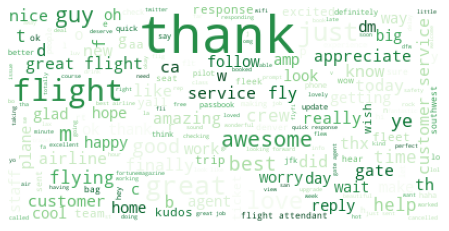

In [524]:
# OPTINAL: wordcloud for positive comments 
from wordcloud import WordCloud
wc = WordCloud(background_color='white', stopwords=stopwords, max_font_size=48, random_state=42,
               colormap='Greens')
wc.generate(df_pos['token'].to_string())
plt.imshow(wc)
plt.axis('off')
plt.show()

In [525]:
lda_model_20_pos = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online')
topics_20_pos = lda_model_20_pos.fit_transform(X1)

In [526]:
lda_model_10_pos = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
topics_10_pos = lda_model_10_pos.fit_transform(X1)

In [527]:
lda_model_5_pos = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
topics_5_pos = lda_model_5_pos.fit_transform(X1)

In [528]:
lda_model_4_pos = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online')
topics_4_pos = lda_model_4_pos.fit_transform(X1)

In [529]:
lda_model_3_pos = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
topics_3_pos = lda_model_3_pos.fit_transform(X1)

In [530]:
lda_model_2_pos = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
topics_2_pos = lda_model_2_pos.fit_transform(X1)

In [532]:
# Get the topics and n_top_words for 20 topics 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model20_pos = lda_model_20_pos
n_top_words20_pos = 10
topic_words20_pos = {}
vocab20_pos = vectorizer4.get_feature_names()

for topic, comp in enumerate(model20_pos.components_):  
    word_idx20_pos = np.argsort(comp)[::-1][:n_top_words20_pos]
    # store the words most relevant to the topic
    topic_words20_pos[topic] = [vocab20_pos[i] for i in word_idx20_pos]

for topic, word in topic_words20_pos.items():
    new_top20_pos = topic+1
    print('Topic: %d' % new_top20_pos)
    print('  %s' % ', '.join(word))

Topic: 1
  thank, thanks, response, home, getting, quick, appreciate, able, quick response, yall
Topic: 2
  aa, passbook, lt, th, flight crew, set, luck, eventually, airlines, dealing
Topic: 3
  love, best, guy, flight, just, southwest, booking, bos, flightled, cancelled flightled
Topic: 4
  flying, year, finally, just, love, app, newark, wanted, love flying, mind
Topic: 5
  airline, day, thank, great, flight, happy, tomorrow, looking, best, forward
Topic: 6
  great, crew, flight, great flight, jfk, thanks, upgrade, landing, friendly, im
Topic: 7
  team, social, flyfi, high, deserves, commercial, medium, social medium, power, absolute
Topic: 8
  phl, austin, cold, phx, cabin, left, bringing, come, terry, bring
Topic: 9
  flight, time, awesome, thanks, yes, attendant, flight attendant, morning, cancelled, kudos
Topic: 10
  amp, thank, today, help, appreciate, really, fly, weather, airport, flight
Topic: 11
  thanks, flight, wait, did, ca, ticket, just, boarding, nice, right
Topic: 12
  

In [533]:
# Visualize the 20 topics using LDSvis (not great!)
import pyLDAvis.sklearn as LDAvis
pyLDAvis.enable_notebook()
#creating visualization for k20 clusters for positive speech
panel20_pos = LDAvis.prepare(lda_model_20_pos, X1, vectorizer4)
#visualizing output for 20 clusters-- viz will be saved in your folder
pyLDAvis.save_html(panel20_pos,'panel20_viz_pos.html')

In [695]:
panel20_pos

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.230809  0.114990       1        1  9.227214
8     -0.140140 -0.153528       2        1  8.697903
4     -0.072939 -0.112182       3        1  7.802044
9     -0.118289  0.053542       4        1  6.630065
17    -0.091940  0.013047       5        1  6.563106
13    -0.088549  0.136686       6        1  6.245088
12     0.004357  0.095147       7        1  6.043357
10    -0.150056 -0.019933       8        1  5.940061
2     -0.033772 -0.036538       9        1  5.689121
15    -0.110745  0.176776      10        1  5.191998
5     -0.058443 -0.244911      11        1  4.936634
14     0.158821 -0.087906      12        1  4.314227
18     0.132986  0.109892      13        1  4.258799
11     0.029541 -0.222254      14        1  3.911331
19     0.105431 -0.055004      15        1  3.633390
3      0.098848  0.090723      16        1  2.932583
16     0.108609  0.037659      17        1  2.421075
1      0.158943  0.026696      18        1  2.175858
6      0.150910  0.044344      19        1  1.741737
7      0.147239  0.032752      20        1  1.644408, topic_info=         Term        Freq       Total Category  logprob  loglift
1136    thank  389.000000  389.000000  Default  30.0000  30.0000
1159   thanks  542.000000  542.000000  Default  29.0000  29.0000
522     great  218.000000  218.000000  Default  28.0000  28.0000
412    flight  397.000000  397.000000  Default  27.0000  27.0000
1020  service  157.000000  157.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
876       phx    8.065451   11.752138  Topic20  -3.3662   3.7313
77     austin    9.008367   13.867087  Topic20  -3.2556   3.6764
223      come    5.902942    9.480497  Topic20  -3.6783   3.6340
699      left    7.716077   13.819337  Topic20  -3.4105   3.5250
974      rock    3.655065   29.803255  Topic20  -4.1577   2.0093

[840 rows x 6 columns], token_table=      Topic      Freq                     Term
term                                          
0        18  0.968992                       aa
1         1  0.789148                     able
1         4  0.166136                     able
3        19  0.825407                 absolute
9         2  0.545290                 actually
...     ...       ...                      ...
1343     16  0.813299  year newark love flying
1345      2  0.975138                      yes
1349     11  0.870729                  yes yes
1350      7  0.252816                yesterday
1350     14  0.632039                yesterday

[979 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 5, 10, 18, 14, 13, 11, 3, 16, 6, 15, 19, 12, 20, 4, 17, 2, 7, 8])

In [535]:
# Get the topics and n_top_words for 10 topics 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model10_pos = lda_model_10_pos
n_top_words10_pos = 10
topic_words10_pos = {}
vocab10_pos = vectorizer4.get_feature_names()

for topic, comp in enumerate(model10_pos.components_):  
    word_idx10_pos = np.argsort(comp)[::-1][:n_top_words10_pos]
    # store the words most relevant to the topic
    topic_words10_pos[topic] = [vocab10_pos[i] for i in word_idx10_pos]

for topic, word in topic_words10_pos.items():
    new_top10_pos = topic+1
    print('Topic: %d' % new_top10_pos)
    print('  %s' % ', '.join(word))

panel10_pos = LDAvis.prepare(lda_model_10_pos, X1, vectorizer4)
pyLDAvis.save_html(panel10_pos,'panel10_viz_pos.html')

Topic: 1
  best, airline, home, happy, tonight, haha, ticket, best airline, blue, say
Topic: 2
  good, love, trip, southwest, work, cool, look, good work, bos, class
Topic: 3
  thank, thanks, better, care, appreciated, love, taking, oh, wifi, twitter
Topic: 4
  service, customer, customer service, awesome, flight, thx, time, morning, cancelled, change
Topic: 5
  thank, day, know, gate, flight, agent, really, good, amazing, crew
Topic: 6
  thanks, just, new, like, plane, help, flying, hope, follow, make
Topic: 7
  aa, airline, long, love, upgrade, need, wish, warm, family, issue
Topic: 8
  flight, just, thanks, amp, finally, staff, free, making, helpful, pilot
Topic: 9
  flight, guy, yes, thanks, attendant, great, work, crew, time, flight attendant
Topic: 10
  great, thanks, thank, today, flight, appreciate, job, response, did, quick


In [696]:
panel10_pos

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.046894  0.061128       1        1  13.342548
5      0.140236 -0.027536       2        1  13.304172
9      0.201531 -0.051854       3        1  13.081856
4      0.063124 -0.133215       4        1  12.973470
3      0.005271  0.314320       5        1  11.225310
7      0.105276  0.082130       6        1   9.588379
2      0.042628 -0.135531       7        1   7.164797
1     -0.167794 -0.135076       8        1   6.946426
6     -0.174758 -0.006953       9        1   6.268505
0     -0.262408  0.032587      10        1   6.104536, topic_info=          Term        Freq       Total Category  logprob  loglift
1136     thank  401.000000  401.000000  Default  30.0000  30.0000
1159    thanks  558.000000  558.000000  Default  29.0000  29.0000
1020   service  156.000000  156.000000  Default  28.0000  28.0000
522      great  215.000000  215.000000  Default  27.0000  27.0000
270   customer  118.000000  118.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
157   business    8.827012   11.865592  Topic10  -4.5876   2.5003
1217    ticket   16.788229   28.086797  Topic10  -3.9447   2.2815
21     airline   37.074053   89.390451  Topic10  -3.1525   1.9160
1080     staff    8.061739   42.615109  Topic10  -4.6783   1.1311
340      early    6.709407   17.132056  Topic10  -4.8619   1.8587

[477 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         5  0.262867         aa
0         9  0.740808         aa
16        3  0.084349      agent
16        4  0.801314      agent
16        9  0.105436      agent
...     ...       ...        ...
1337      5  0.704799       yall
1340      2  0.905263       year
1340      3  0.078719       year
1345      1  0.988521        yes
1350      5  0.897547  yesterday

[564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 5, 4, 8, 3, 2, 7, 1])

In [697]:
# Get the topics and n_top_words for 5 topics 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model5_pos = lda_model_5_pos
n_top_words5_pos = 10
topic_words5_pos = {}
vocab5_pos = vectorizer4.get_feature_names()

for topic, comp in enumerate(model5_pos.components_):  
    word_idx5_pos = np.argsort(comp)[::-1][:n_top_words5_pos]
    # store the words most relevant to the topic
    topic_words5_pos[topic] = [vocab5_pos[i] for i in word_idx5_pos]

for topic, word in topic_words5_pos.items():
    new_top5_pos = topic+1
    print('Topic: %d' % new_top5_pos)
    print('  %s' % ', '.join(word))

panel5_pos = LDAvis.prepare(lda_model_5_pos, X1, vectorizer4)
panel5_pos

Topic: 1
  thank, flight, thanks, make, response, appreciate, great, home, follow, cancelled
Topic: 2
  love, airline, plane, great, best, flight, gate, flying, staff, amazing
Topic: 3
  flight, guy, thanks, great, awesome, did, crew, better, just, ok
Topic: 4
  thanks, service, customer, thank, customer service, help, great, today, yes, flight
Topic: 5
  just, thanks, flight, good, time, day, attendant, work, ca, wait


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.031310 -0.073124       1        1  24.088945
1     -0.225697 -0.078651       2        1  20.572632
0      0.245765 -0.116960       3        1  20.253027
4      0.042427  0.282544       4        1  18.212569
2     -0.093804 -0.013809       5        1  16.872827, topic_info=          Term        Freq       Total Category  logprob  loglift
1136     thank  406.000000  406.000000  Default  30.0000  30.0000
1020   service  153.000000  153.000000  Default  29.0000  29.0000
1159    thanks  562.000000  562.000000  Default  28.0000  28.0000
270   customer  116.000000  116.000000  Default  27.0000  27.0000
548        guy  107.000000  107.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
715       long   14.052418   21.341527   Topic5  -5.1393   1.3616
1248      trip   15.467291   36.440207   Topic5  -5.0434   0.9225
452        fly   16.449149   54.855602   Topic5  -4.9818   0.5750
681       know   16.234644   53.892613   Topic5  -4.9949   0.5796
730       love   14.294103  128.018990   Topic5  -5.1222  -0.4129

[270 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         2  0.049926     aa
0         3  0.599111     aa
0         4  0.174741     aa
0         5  0.174741     aa
1         1  0.353781   able
...     ...       ...    ...
1333      3  0.122296  worry
1333      4  0.856073  worry
1340      1  0.266458   year
1340      4  0.685178   year
1345      1  0.981426    yes

[309 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 3])

In [539]:
pyLDAvis.save_html(panel5_pos,'panel5_viz_pos.html')

In [698]:
# Get the topics and n_top_words for 4 topics 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model4_pos = lda_model_4_pos
n_top_words4_pos = 10
topic_words4_pos = {}
vocab4_pos = vectorizer4.get_feature_names()

for topic, comp in enumerate(model4_pos.components_):  
    word_idx4_pos = np.argsort(comp)[::-1][:n_top_words4_pos]
    # store the words most relevant to the topic
    topic_words4_pos[topic] = [vocab4_pos[i] for i in word_idx4_pos]

for topic, word in topic_words4_pos.items():
    new_top4_pos = topic+1
    print('Topic: %d' % new_top4_pos)
    print('  %s' % ', '.join(word))

panel4_pos = LDAvis.prepare(lda_model_4_pos, X1, vectorizer4)
panel4_pos

Topic: 1
  thanks, flight, good, thank, response, airline, time, plane, follow, week
Topic: 2
  flight, thanks, great, gate, did, crew, yes, airport, job, just
Topic: 3
  love, guy, awesome, flight, thanks, flying, attendant, best, experience, amp
Topic: 4
  thank, thanks, service, customer, just, great, customer service, help, like, amazing


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.032424 -0.136244       1        1  31.202160
1     -0.159124 -0.137556       2        1  25.920064
0      0.239492  0.038071       3        1  21.556564
2     -0.112792  0.235729       4        1  21.321212, topic_info=         Term        Freq       Total Category  logprob  loglift
1136    thank  406.000000  406.000000  Default  30.0000  30.0000
730      love  129.000000  129.000000  Default  29.0000  29.0000
1020  service  152.000000  152.000000  Default  28.0000  28.0000
548       guy  107.000000  107.000000  Default  27.0000  27.0000
511      good  106.000000  106.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1220     time   30.249912  102.647820   Topic4  -4.6066   0.3237
813       new   20.545859   52.199717   Topic4  -4.9934   0.6131
1216      thx   18.178143   43.453411   Topic4  -5.1159   0.6740
21    airline   20.466498   87.901294   Topic4  -4.9973   0.0880
660      just   20.482475  161.734324   Topic4  -4.9965  -0.5209

[224 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         2  0.766588     aa
0         3  0.197829     aa
16        1  0.307062  agent
16        2  0.593653  agent
16        4  0.081883  agent
...     ...       ...    ...
1337      1  0.915487   yall
1337      4  0.096367   yall
1340      1  0.037628   year
1340      4  0.978326   year
1345      2  0.976276    yes

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [541]:
pyLDAvis.save_html(panel4_pos,'panel4_viz_pos.html')

In [699]:
# Get the topics and n_top_words for 3 topics 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model3_pos = lda_model_3_pos
n_top_words3_pos = 10
topic_words3_pos = {}
vocab3_pos = vectorizer4.get_feature_names()

for topic, comp in enumerate(model3_pos.components_):  
    word_idx3_pos = np.argsort(comp)[::-1][:n_top_words3_pos]
    # store the words most relevant to the topic
    topic_words3_pos[topic] = [vocab3_pos[i] for i in word_idx3_pos]

for topic, word in topic_words3_pos.items():
    new_top3_pos = topic+1
    print('Topic: %d' % new_top3_pos)
    print('  %s' % ', '.join(word))

panel3_pos = LDAvis.prepare(lda_model_3_pos, X1, vectorizer4)
panel3_pos

Topic: 1
  flight, great, thanks, crew, time, gate, response, plane, home, good
Topic: 2
  service, thanks, customer, customer service, help, good, flight, today, thx, amp
Topic: 3
  thank, thanks, just, love, guy, airline, best, fly, yes, flying


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.072956 -0.197919       1        1  38.245791
2     -0.238673  0.045400       2        1  33.631195
1      0.165717  0.152519       3        1  28.123014, topic_info=            Term        Freq       Total Category  logprob  loglift
1136       thank  414.000000  414.000000  Default  30.0000  30.0000
412       flight  396.000000  396.000000  Default  29.0000  29.0000
1020     service  157.000000  157.000000  Default  28.0000  28.0000
270     customer  119.000000  119.000000  Default  27.0000  27.0000
522        great  216.000000  216.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
57    appreciate   25.465723   63.226951   Topic3  -5.0556   0.3592
169    cancelled   19.207723   35.775286   Topic3  -5.3377   0.6466
1           able   17.363638   26.072801   Topic3  -5.4386   0.8621
36       amazing   19.129078   70.113557   Topic3  -5.3418  -0.0303
108         best   19.593900   92.936524   Topic3  -5.3178  -0.2881

[176 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.423897    aa
0         2  0.498702    aa
0         3  0.074805    aa
1         1  0.038354  able
1         2  0.306833  able
...     ...       ...   ...
1325      2  0.018774  work
1325      3  0.563222  work
1337      2  0.846385  yall
1337      3  0.141064  yall
1345      2  0.981092   yes

[209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [700]:
# Get the topics and n_top_words for 2 topics 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model2_pos = lda_model_2_pos
n_top_words2_pos = 10
topic_words2_pos = {}
vocab2_pos = vectorizer4.get_feature_names()

for topic, comp in enumerate(model2_pos.components_):  
    word_idx2_pos = np.argsort(comp)[::-1][:n_top_words2_pos]
    # store the words most relevant to the topic
    topic_words2_pos[topic] = [vocab2_pos[i] for i in word_idx2_pos]

for topic, word in topic_words2_pos.items():
    new_top2_pos = topic+1
    print('Topic: %d' % new_top2_pos)
    print('  %s' % ', '.join(word))

panel2_pos = LDAvis.prepare(lda_model_2_pos, X1, vectorizer4)
panel2_pos

Topic: 1
  thanks, just, love, airline, guy, good, flying, appreciate, gate, response
Topic: 2
  thank, flight, great, service, customer, customer service, thanks, help, today, best


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.155112  0.0       1        1  50.546088
0     -0.155112  0.0       2        1  49.453912, topic_info=         Term        Freq       Total Category  logprob  loglift
1136    thank  414.000000  414.000000  Default  30.0000  30.0000
1159   thanks  566.000000  566.000000  Default  29.0000  29.0000
412    flight  398.000000  398.000000  Default  28.0000  28.0000
1020  service  156.000000  156.000000  Default  27.0000  27.0000
660      just  163.000000  163.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
412    flight   55.534371  398.472188   Topic2  -4.8404  -1.2665
882     plane   35.093253   65.033633   Topic2  -5.2994   0.0872
108      best   37.577064   92.803479   Topic2  -5.2310  -0.2000
16      agent   32.196782   49.000826   Topic2  -5.3856   0.2842
258      crew   33.210876   76.325410   Topic2  -5.3546  -0.1280

[138 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
16        1  0.346933      agent
16        2  0.653050      agent
19        1  0.952571        air
19        2  0.050135        air
21        1  0.034537    airline
...     ...       ...        ...
1319      2  0.965445       wish
1322      1  0.942346  wonderful
1322      2  0.044874  wonderful
1345      1  0.020891        yes
1345      2  0.981896        yes

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [544]:
# Check log-likelihood for positive comments
print("20 Topics Log Likelihood for positive comments: ", lda_model_20_pos.score(X1))
print("10 Topics Log Likelihood for positive comments: ", lda_model_10_pos.score(X1))
print("5 Topics Log Likelihood for positive comments: ", lda_model_5_pos.score(X1))
print("4 Topics Log Likelihood for positive comments: ", lda_model_4_pos.score(X1))
print("3 Topics Log Likelihood for positive comments: ", lda_model_3_pos.score(X1))
print("2 Topics Log Likelihood for positive comments: ", lda_model_2_pos.score(X1))

20 Topics Log Likelihood for positive comments:  -97906.54079275196
10 Topics Log Likelihood for positive comments:  -96809.95994583963
5 Topics Log Likelihood for positive comments:  -95289.91846719407
4 Topics Log Likelihood for positive comments:  -95032.33459894209
3 Topics Log Likelihood for positive comments:  -94113.50113551218
2 Topics Log Likelihood for positive comments:  -93538.20085373441


In [546]:
#Check perplexity score of modles: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

print("20 Topics perplexity for positive comments: ", lda_model_20_pos.perplexity(X1))
print("10 Topics perplexity for positive comments:", lda_model_10_pos.perplexity(X1))
print("5 Topics perplexity for positive comments:", lda_model_5_pos.perplexity(X1))
print("4 Topics perplexity for positive comments:", lda_model_4_pos.perplexity(X1))
print("3 Topics perplexity for positive comments:", lda_model_3_pos.perplexity(X1))
print("2 Topics perplexity for positive comments:", lda_model_2_pos.perplexity(X1))

20 Topics perplexity for positive comments:  983.3298262013099
10 Topics perplexity for positive comments: 910.290767104566
5 Topics perplexity for positive comments: 817.9319736896142
4 Topics perplexity for positive comments: 803.23688959569
3 Topics perplexity for positive comments: 752.9354709052519
2 Topics perplexity for positive comments: 723.0571290935178


In [547]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 10, 20]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X1)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [2, 3, 4, 5, 10, 20]})

In [548]:
## OPTIONAL---
best_lda_model_pos = model.best_estimator_
best_lda_model_pos # n_components=20 was considered the best

LatentDirichletAllocation(n_components=2)

In [549]:
print("Grid scores on development set:")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
-21449.684 (+/-1994.354) for {'n_components': 2}
-22556.964 (+/-2024.944) for {'n_components': 3}
-23484.642 (+/-2116.842) for {'n_components': 4}
-24264.989 (+/-2037.863) for {'n_components': 5}
-27251.570 (+/-2337.143) for {'n_components': 10}
-31395.081 (+/-2518.197) for {'n_components': 20}


### Alternative LDA in sklearn for negative comments 

In [551]:
##For negative comments

import warnings
warnings.filterwarnings("ignore")

max_ngram_4 = 4

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", 'm', "s", "wa", "would", "could", "might", "ha", "ve", "nt", 'd',"ll", 't', 'f']

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

# Vectorize using TFIDF (vectorizer 5 (very similar to vectorizer 3 tfidf)) because it has the best performance with the classification

vectorizer5 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 2000
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram_4))

X2 = vectorizer5.fit_transform(df_neg['token']) #X2 only included tokens from positive comments 
X2.shape

(9178, 5912)

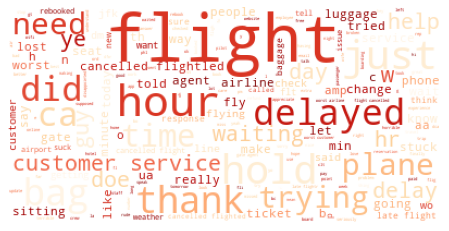

In [552]:
# OPTINAL: wordcloud for negative comments 
from wordcloud import WordCloud
wc = WordCloud(background_color='white', stopwords=stopwords, max_font_size=60, random_state=42,
               colormap='OrRd')
wc.generate(df_neg['token'].to_string())
plt.imshow(wc)
plt.axis('off')
plt.show()

In [553]:
#Building the models with different numbers of topics for negative comments: 

#20 topics 
lda_model_20_neg = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method='online')
topics_20_neg = lda_model_20_neg.fit_transform(X2)
#10 topics
lda_model_10_neg = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online')
topics_10_neg = lda_model_10_neg.fit_transform(X2)
#5 topics
lda_model_5_neg = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
topics_5_neg = lda_model_5_neg.fit_transform(X2)
#4 topics
lda_model_4_neg = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online')
topics_4_neg = lda_model_4_neg.fit_transform(X2)
#3 topics
lda_model_3_neg = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
topics_3_neg = lda_model_3_neg.fit_transform(X2)
#2 topics
lda_model_2_neg = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
topics_2_neg = lda_model_2_neg.fit_transform(X2)

In [701]:
#20 topics modeling with negative comments
# Get the topics and n_top_words for 20 topics 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model20_neg = lda_model_20_neg
n_top_words20_neg = 10
topic_words20_neg = {}
vocab20_neg = vectorizer5.get_feature_names()

for topic, comp in enumerate(model20_neg.components_):  
    word_idx20_neg = np.argsort(comp)[::-1][:n_top_words20_neg]
    # store the words most relevant to the topic
    topic_words20_neg[topic] = [vocab20_neg[i] for i in word_idx20_neg]

for topic, word in topic_words20_neg.items():
    new_top20_neg = topic+1
    print('Topic: %d' % new_top20_neg)
    print('  %s' % ', '.join(word))
    
#creating visualization for k20 clusters for positive speech
panel20_neg = LDAvis.prepare(lda_model_20_neg, X2, vectorizer5)
#visualizing output for 20 clusters-- viz will be saved in your folder
pyLDAvis.save_html(panel20_neg,'panel20_viz_neg.html')
#visualize the 20 topics in negative comments
panel20_neg

Topic: 1
  airline, worst, min, like, just, said, crew, guy, long, response
Topic: 2
  late, hr, late flight, flightr, late flightr, use, fix, pilot, hour late, app
Topic: 3
  cancelled, flightled, cancelled flightled, flight cancelled, home, flight cancelled flightled, tomorrow, flightled flight, better, cancelled flightled flight
Topic: 4
  doe, thanks, miss, email, bag, morning, care, look, wrong, mean
Topic: 5
  line, did, rebooked, board, check, horrible, agent, make, reach, checked
Topic: 6
  weather, suck, hang, tweet, sat, provide, hoping, waiting hour, attitude, bad weather
Topic: 7
  cancelled, flighted, cancelled flighted, hour, stuck, new, dfw, delayed, rebook, hotel
Topic: 8
  say, flt, mile, fail, paid, tell, food, upgrade, ur, love
Topic: 9
  day, hour, luggage, bag, people, travel, want, jfk, left, plane
Topic: 10
  experience, bad, seat, booked, good, week, point, day, business, available
Topic: 11
  hold, delay, going, hold hour, time, today, think, pm, extra, departu

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.200283 -0.010091       1        1  7.795605
19     0.202039  0.020671       2        1  6.791852
2     -0.068683  0.264896       3        1  6.547942
8     -0.081340 -0.045608       4        1  6.498955
0      0.004243 -0.126556       5        1  6.359657
6     -0.046894  0.263180       6        1  6.062211
12     0.237311  0.016750       7        1  5.804490
15    -0.086578  0.084785       8        1  5.646495
13    -0.211437 -0.059423       9        1  5.534225
1     -0.027198 -0.087845      10        1  4.785979
10     0.100250  0.055962      11        1  4.640941
3      0.031218 -0.156727      12        1  4.542877
17     0.055460 -0.011124      13        1  4.537174
18    -0.055646  0.156882      14        1  4.404445
9     -0.011833 -0.016296      15        1  4.347382
14     0.078292 -0.043567      16        1  3.711639
7     -0.049172 -0.079726      17        1  3.391017
4     -0.076317 -0.073337      18        1  3.388811
16    -0.148514 -0.087341      19        1  2.984870
5     -0.045485 -0.065483      20        1  2.223433, topic_info=               Term        Freq       Total Category  logprob  loglift
1131       customer  714.000000  714.000000  Default  30.0000  30.0000
702       cancelled  884.000000  884.000000  Default  29.0000  29.0000
4657        service  700.000000  700.000000  Default  28.0000  28.0000
2606           hold  602.000000  602.000000  Default  27.0000  27.0000
3991          plane  557.000000  557.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
3592          nasty   10.957480   11.846882  Topic20  -5.1871   3.7281
5726  weather delay   10.843794   11.733196  Topic20  -5.1975   3.7273
4543      sat plane   10.781844   11.671246  Topic20  -5.2032   3.7269
5733            web   15.457966   18.250248  Topic20  -4.8430   3.6401
3190           like   21.582166  271.304100  Topic20  -4.5092   1.2747

[847 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.995921          aa
14        6  0.172075        able
14       17  0.817359        able
21        3  0.963043  absolutely
27       18  0.950819  acceptable
...     ...       ...         ...
5884     19  0.952974    year old
5889      8  0.996192         yes
5895      6  0.994316   yesterday
5904     14  0.947410          yr
5908      8  0.986270        zero

[948 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 20, 3, 9, 1, 7, 13, 16, 14, 2, 11, 4, 18, 19, 10, 15, 8, 5, 17, 6])

In [702]:
# Get the topics and n_top_words for 10 topics for negative comments
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model10_neg = lda_model_10_neg
n_top_words10_neg = 10
topic_words10_neg = {}
vocab10_neg = vectorizer5.get_feature_names()

for topic, comp in enumerate(model10_neg.components_):  
    word_idx10_neg = np.argsort(comp)[::-1][:n_top_words10_neg]
    # store the words most relevant to the topic
    topic_words10_neg[topic] = [vocab10_neg[i] for i in word_idx10_neg]

for topic, word in topic_words10_neg.items():
    new_top10_neg = topic+1
    print('Topic: %d' % new_top10_neg)
    print('  %s' % ', '.join(word))

panel10_neg = LDAvis.prepare(lda_model_10_neg, X2, vectorizer5)
pyLDAvis.save_html(panel10_neg,'panel10_viz_neg.html')

panel10_neg

Topic: 1
  bag, agent, going, gate, baggage, help, connection, yes, dfw, lost
Topic: 2
  day, weather, say, bad, email, tell, tried, thanks, supposed, different
Topic: 3
  cancelled, waiting, airport, flightled, cancelled flightled, know, need, flight cancelled, flight cancelled flightled, refund
Topic: 4
  hold, hour, phone, delay, minute, seat, help, reservation, ca, min
Topic: 5
  plane, hour, delayed, time, change, issue, gate, min, sitting, hold hour
Topic: 6
  worst, did, thanks, like, airline, want, hour, travel, jfk, pay
Topic: 7
  customer, service, customer service, aa, trip, speak, ca, care, available, horrible
Topic: 8
  cancelled, flightled, cancelled flightled, flighted, cancelled flighted, home, said, hotel, flightled flight, cancelled flightled flight
Topic: 9
  hr, time, experience, getting, fly, way, new, boarding, amp, help
Topic: 10
  late, people, check, ticket, trying, flightr, doe, late flightr, just, late flight


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.068182  0.186947       1        1  13.669114
3     -0.020077  0.116795       2        1  12.332907
0     -0.088614  0.166495       3        1  10.321486
9     -0.178476 -0.010207       4        1  10.114105
2      0.273552  0.039042       5        1   9.992906
6     -0.069414 -0.179284       6        1   9.843900
7      0.298776 -0.039273       7        1   9.565929
5     -0.067294 -0.162860       8        1   8.726676
8     -0.037229  0.104706       9        1   8.357119
1     -0.043042 -0.222362      10        1   7.075859, topic_info=           Term        Freq       Total Category  logprob  loglift
1131   customer  721.000000  721.000000  Default  30.0000  30.0000
4657    service  705.000000  705.000000  Default  29.0000  29.0000
702   cancelled  894.000000  894.000000  Default  28.0000  28.0000
3991      plane  548.000000  548.000000  Default  27.0000  27.0000
2606       hold  599.000000  599.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
3279       look   47.204136   79.699217  Topic10  -4.8843   2.1247
5131     thanks   82.183836  298.709926  Topic10  -4.3298   1.3580
1375        did   44.535478  357.184354  Topic10  -4.9424   0.5665
5269      today   41.449431  251.851435  Topic10  -5.0143   0.8441
5195       time   42.089003  676.407753  Topic10  -4.9989  -0.1285

[485 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         6  0.997981          aa
14        6  0.114781        able
14        9  0.875206        able
27       10  0.955968  acceptable
38        3  0.991656     account
...     ...       ...         ...
5880      7  0.149187        year
5880     10  0.840875        year
5889      3  0.993053         yes
5895      7  0.995641   yesterday
5904     10  0.951018          yr

[582 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 10, 3, 7, 8, 6, 9, 2])

In [703]:
# Get the topics and n_top_words for 5 topics for negative comments
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model5_neg = lda_model_5_neg
n_top_words5_neg = 10
topic_words5_neg = {}
vocab5_neg = vectorizer5.get_feature_names()

for topic, comp in enumerate(model5_neg.components_):  
    word_idx5_neg = np.argsort(comp)[::-1][:n_top_words5_neg]
    # store the words most relevant to the topic
    topic_words5_neg[topic] = [vocab5_neg[i] for i in word_idx5_neg]

for topic, word in topic_words5_neg.items():
    new_top5_neg = topic+1
    print('Topic: %d' % new_top5_neg)
    print('  %s' % ', '.join(word))

panel5_neg = LDAvis.prepare(lda_model_5_neg, X2, vectorizer5)
pyLDAvis.save_html(panel5_neg,'panel5_viz_neg.html')
panel5_neg

Topic: 1
  hour, hold, plane, bag, help, just, min, phone, ca, minute
Topic: 2
  cancelled, flightled, cancelled flightled, flight cancelled, issue, flighted, cancelled flighted, home, tomorrow, flight cancelled flightled
Topic: 3
  day, service, customer, waiting, hr, amp, customer service, worst, airport, airline
Topic: 4
  delayed, delay, hour, seat, aa, way, gate, late, time, late flight
Topic: 5
  customer, service, going, time, customer service, like, fly, people, late, getting


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.078111  0.124939       1        1  23.191634
3     -0.084259  0.248735       2        1  21.275330
2      0.125943 -0.079646       3        1  20.699588
1     -0.223939 -0.242209       4        1  18.121583
4      0.260366 -0.051819       5        1  16.711865, topic_info=           Term        Freq       Total Category  logprob  loglift
702   cancelled  890.000000  890.000000  Default  30.0000  30.0000
2606       hold  600.000000  600.000000  Default  29.0000  29.0000
3991      plane  544.000000  544.000000  Default  28.0000  28.0000
2129  flightled  435.000000  435.000000  Default  27.0000  27.0000
1131   customer  731.000000  731.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2990       just  118.758861  570.284804   Topic5  -4.8211   0.2200
3163        let   76.911568  168.421203   Topic5  -5.2555   1.0052
5269      today   80.656328  252.267478   Topic5  -5.2080   0.6488
628          ca   80.753764  439.033215   Topic5  -5.2068   0.0959
4238     really   71.580205  219.619486   Topic5  -5.3273   0.6680

[272 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         2  0.996186       aa
14        3  0.987277     able
38        1  0.992186  account
79        1  0.117660    agent
79        2  0.391220    agent
...     ...       ...      ...
5828      5  0.991099    worse
5831      3  0.996809    worst
5860      2  0.983943    wrong
5880      4  0.081062     year
5880      5  0.918699     year

[346 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

In [704]:
# Get the topics and n_top_words for 4 topics for negative comments (This might be the words selected)
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model4_neg = lda_model_4_neg
n_top_words4_neg = 10
topic_words4_neg = {}
vocab4_neg = vectorizer5.get_feature_names()

for topic, comp in enumerate(model4_neg.components_):  
    word_idx4_neg = np.argsort(comp)[::-1][:n_top_words4_neg]
    # store the words most relevant to the topic
    topic_words4_neg[topic] = [vocab4_neg[i] for i in word_idx4_neg]

for topic, word in topic_words4_neg.items():
    new_top4_neg = topic+1
    print('Topic: %d' % new_top4_neg)
    print('  %s' % ', '.join(word))

panel4_neg = LDAvis.prepare(lda_model_4_neg, X2, vectorizer5)
pyLDAvis.save_html(panel4_neg,'panel4_viz_neg.html')
panel4_neg

Topic: 1
  bag, hour, late, delay, plane, amp, min, gate, late flight, day
Topic: 2
  customer, service, customer service, airline, waiting, worst, time, sitting, work, people
Topic: 3
  delayed, agent, day, issue, going, plane, ca, stuck, like, flight delayed
Topic: 4
  cancelled, hold, flightled, cancelled flightled, hour, help, phone, flight cancelled, change, time


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.292753  0.048740       1        1  26.051345
1     -0.084796 -0.212534       2        1  25.893489
0     -0.151895  0.241133       3        1  25.537389
2     -0.056062 -0.077339       4        1  22.517776, topic_info=           Term        Freq        Total Category  logprob  loglift
702   cancelled  884.000000   884.000000  Default  30.0000  30.0000
1131   customer  721.000000   721.000000  Default  29.0000  29.0000
4657    service  705.000000   705.000000  Default  28.0000  28.0000
374         bag  600.000000   600.000000  Default  27.0000  27.0000
1281    delayed  455.000000   455.000000  Default  26.0000  26.0000
...         ...         ...          ...      ...      ...      ...
2201        fly   90.681285   220.568688   Topic4  -5.3890   0.6020
3852  passenger   88.995502   164.388805   Topic4  -5.4078   0.8772
2990       just   95.903778   571.824551   Topic4  -5.3330  -0.2946
2553       help   93.195961   597.994961   Topic4  -5.3616  -0.3680
2708       hour   92.103060  1031.388325   Topic4  -5.3734  -0.9249

[241 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.159525     aa
0         2  0.528951     aa
0         3  0.310654     aa
79        4  0.998596  agent
103       3  0.991244    ago
...     ...       ...    ...
5791      3  0.054771     wo
5812      2  0.995370   work
5828      4  0.987642  worse
5831      2  0.997962  worst
5880      4  0.994920   year

[299 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [705]:
# Get the topics and n_top_words for 3 topics for negative comments (This is great!! - bag/airline agent hold call/ cancel&delay
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model3_neg = lda_model_3_neg
n_top_words3_neg = 10
topic_words3_neg = {}
vocab3_neg = vectorizer5.get_feature_names()

for topic, comp in enumerate(model3_neg.components_):  
    word_idx3_neg = np.argsort(comp)[::-1][:n_top_words3_neg]
    # store the words most relevant to the topic
    topic_words3_neg[topic] = [vocab3_neg[i] for i in word_idx3_neg]

for topic, word in topic_words3_neg.items():
    new_top3_neg = topic+1
    print('Topic: %d' % new_top3_neg)
    print('  %s' % ', '.join(word))

panel3_neg = LDAvis.prepare(lda_model_3_neg, X2, vectorizer5)
pyLDAvis.save_html(panel3_neg,'panel3_viz_neg.html')
panel3_neg

Topic: 1
  time, hold, hour, agent, airline, aa, minute, worst, phone, wait
Topic: 2
  hour, plane, delayed, bag, late, delay, waiting, gate, hr, time
Topic: 3
  cancelled, customer, service, flightled, help, cancelled flightled, customer service, day, need, amp


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.246756 -0.040205       1        1  36.610751
2      0.161004 -0.177652       2        1  36.013507
0      0.085753  0.217857       3        1  27.375742, topic_info=                     Term        Freq       Total Category  logprob  loglift
1131             customer  714.000000  714.000000  Default  30.0000  30.0000
702             cancelled  885.000000  885.000000  Default  29.0000  29.0000
3991                plane  561.000000  561.000000  Default  28.0000  28.0000
2129            flightled  431.000000  431.000000  Default  27.0000  27.0000
728   cancelled flightled  427.000000  427.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
3360                 make  100.111984  222.182765   Topic3  -5.4854   0.4983
3472                  min  101.475566  312.645587   Topic3  -5.4719   0.1703
4657              service  100.001573  701.847096   Topic3  -5.4865  -0.6530
2623            hold hour   92.279516  143.785710   Topic3  -5.5669   0.8520
2387                going   91.770630  241.026151   Topic3  -5.5724   0.3299

[195 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.083824         aa
0         2  0.004191         aa
0         3  0.913684         aa
79        2  0.246625      agent
79        3  0.751759      agent
...     ...       ...        ...
5880      3  0.994756       year
5889      1  0.085603        yes
5889      2  0.007782        yes
5889      3  0.910507        yes
5895      2  0.996602  yesterday

[253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [706]:
# Get the topics and n_top_words for 2 topics for negative comments
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model2_neg = lda_model_2_neg
n_top_words2_neg = 10
topic_words2_neg = {}
vocab2_neg = vectorizer5.get_feature_names()

for topic, comp in enumerate(model2_neg.components_):  
    word_idx2_neg = np.argsort(comp)[::-1][:n_top_words2_neg]
    # store the words most relevant to the topic
    topic_words2_neg[topic] = [vocab2_neg[i] for i in word_idx2_neg]

for topic, word in topic_words2_neg.items():
    new_top2_neg = topic+1
    print('Topic: %d' % new_top2_neg)
    print('  %s' % ', '.join(word))

panel2_neg = LDAvis.prepare(lda_model_2_neg, X2, vectorizer5)
pyLDAvis.save_html(panel2_neg,'panel2_viz_neg.html')
panel2_neg

Topic: 1
  customer, service, hour, bag, plane, delayed, customer service, gate, time, late
Topic: 2
  cancelled, hold, help, flightled, cancelled flightled, hour, phone, day, ca, just


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.168038  0.0       1        1  53.647477
1     -0.168038  0.0       2        1  46.352523, topic_info=           Term        Freq       Total Category  logprob  loglift
702   cancelled  879.000000  879.000000  Default  30.0000  30.0000
2606       hold  593.000000  593.000000  Default  29.0000  29.0000
4657    service  726.000000  726.000000  Default  28.0000  28.0000
374         bag  601.000000  601.000000  Default  27.0000  27.0000
1131   customer  742.000000  742.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
5605       wait  166.400012  260.851610   Topic2  -5.5039   0.3193
4588       seat  177.528963  323.318058   Topic2  -5.4392   0.1694
3499     minute  171.817744  295.830875   Topic2  -5.4719   0.2255
1375        did  176.154287  354.319537   Topic2  -5.4470   0.0701
5131     thanks  160.164446  294.816418   Topic2  -5.5421   0.1587

[137 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
79        1  0.686319    agent
79        2  0.313830    agent
117       1  0.567147  airline
117       2  0.433526  airline
140       1  0.907319  airport
...     ...       ...      ...
5749      2  0.988164     week
5791      1  0.055374       wo
5791      2  0.941360       wo
5831      1  0.811699    worst
5831      2  0.187315    worst

[198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [560]:
# Check log-likelihood for negative comments
print("20 Topics Log Likelihood for negative comments: ", lda_model_20_neg.score(X2))
print("10 Topics Log Likelihood for negative comments: ", lda_model_10_neg.score(X2))
print("5 Topics Log Likelihood for negative comments: ", lda_model_5_neg.score(X2))
print("4 Topics Log Likelihood for negative comments: ", lda_model_4_neg.score(X2))
print("3 Topics Log Likelihood for negative comments: ", lda_model_3_neg.score(X2))
print("2 Topics Log Likelihood for negative comments: ", lda_model_2_neg.score(X2))

20 Topics Log Likelihood for negative comments:  -705006.6056208404
10 Topics Log Likelihood for negative comments:  -695072.9473681744
5 Topics Log Likelihood for negative comments:  -685183.1362324654
4 Topics Log Likelihood for negative comments:  -679417.5364611237
3 Topics Log Likelihood for negative comments:  -676837.7080221041
2 Topics Log Likelihood for negative comments:  -670561.2315247229


In [561]:
#Check perplexity score of modles: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

print("20 Topics perplexity for negative comments: ", lda_model_20_neg.perplexity(X2))
print("10 Topics perplexity for negative comments:", lda_model_10_neg.perplexity(X2))
print("5 Topics perplexity for negative comments:", lda_model_5_neg.perplexity(X2))
print("4 Topics perplexity for negative comments:", lda_model_4_neg.perplexity(X2))
print("3 Topics perplexity for negative comments:", lda_model_3_neg.perplexity(X2))
print("2 Topics perplexity for negative comments:", lda_model_2_neg.perplexity(X2))

20 Topics perplexity for negative comments:  2964.4609571752035
10 Topics perplexity for negative comments: 2648.655361400653
5 Topics perplexity for negative comments: 2367.6696302388223
4 Topics perplexity for negative comments: 2217.824908645093
3 Topics perplexity for negative comments: 2153.8843303155336
2 Topics perplexity for negative comments: 2005.9154137785504


In [562]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 10, 20]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model2 = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model2.fit(X2)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [2, 3, 4, 5, 10, 20]})

In [563]:
## best model for topic modeling negative comments 
best_lda_model_neg = model2.best_estimator_
best_lda_model_neg 

LatentDirichletAllocation(n_components=2)

In [564]:
print("Grid scores on development set:")
means2 = model2.cv_results_['mean_test_score']
stds2 = model2.cv_results_['std_test_score']

for mean, std, params in zip(means2, stds2, model2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
-148572.854 (+/-7242.557) for {'n_components': 2}
-153109.554 (+/-6588.008) for {'n_components': 3}
-157387.887 (+/-6839.526) for {'n_components': 4}
-161330.513 (+/-7084.246) for {'n_components': 5}
-174553.814 (+/-7262.773) for {'n_components': 10}
-192842.956 (+/-6356.794) for {'n_components': 20}


### Topic modeling for different companies 
In this section, we will extract companies' negative reviews and perform topic modelings with their negative comments and see if there are patterns 

In [565]:
# Let's filter for 'negative' labels only for each company: 
df_neg_united= df2[(df2['airline_sentiment'] == 'negative') & (df2['airline'] == 'United')]
df_neg_USAir= df2[(df2['airline_sentiment'] == 'negative') & (df2['airline'] == 'US Airways')]
df_neg_AA = df2[(df2['airline_sentiment'] == 'negative') & (df2['airline'] == 'American')]
df_neg_SW = df2[(df2['airline_sentiment'] == 'negative') & (df2['airline'] == 'Southwest')]
df_neg_Delta = df2[(df2['airline_sentiment'] == 'negative') & (df2['airline'] == 'Delta')]
df_neg_VA = df2[(df2['airline_sentiment'] == 'negative') & (df2['airline'] == 'Virgin America')]

In [566]:
df_neg_VA.head()

,airline_sentiment,negativereason,airline,text,token
3,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,virginamerica it s really aggressive to blast...
4,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,virginamerica and it s a really big bad thing...
5,negative,Can't Tell,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,virginamerica seriously would pay a flight ...
15,negative,Late Flight,Virgin America,@VirginAmerica SFO-PDX schedule is still MIA.,virginamerica sfopdx schedule is still mia
17,negative,Bad Flight,Virgin America,@VirginAmerica I flew from NYC to SFO last we...,virginamerica i flew from nyc to sfo last wee...


In [567]:
neg_count = df_neg.groupby('airline').count().sort_values('airline_sentiment', ascending = False)
print(neg_count)

                airline_sentiment  negativereason  text  token
airline                                                       
United                       2633            2633  2633   2633
US Airways                   2263            2263  2263   2263
American                     1960            1960  1960   1960
Southwest                    1186            1186  1186   1186
Delta                         955             955   955    955
Virgin America                181             181   181    181


Text(0, 0.5, 'The number of reviews')

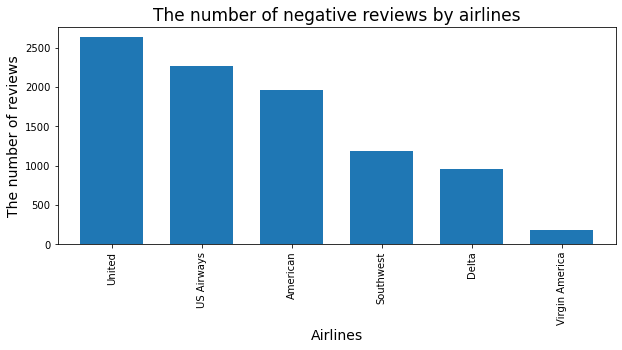

In [568]:
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 4
neg_count['airline_sentiment'].plot(kind = 'bar', width = 0.7)
plt.title("The number of negative reviews by airlines", fontsize= 17)
plt.xlabel("Airlines", fontsize = 14)
plt.ylabel("The number of reviews", fontsize = 14)

In [623]:
neg_reasons = df_neg.groupby('negativereason').count().sort_values('airline_sentiment', ascending = False)
print(neg_reasons)

                             airline_sentiment  airline  text  token
negativereason                                                      
Customer Service Issue                    2910     2910  2910   2910
Late Flight                               1665     1665  1665   1665
Can't Tell                                1190     1190  1190   1190
Cancelled Flight                           847      847   847    847
Lost Luggage                               724      724   724    724
Bad Flight                                 580      580   580    580
Flight Booking Problems                    529      529   529    529
Flight Attendant Complaints                481      481   481    481
longlines                                  178      178   178    178
Damaged Luggage                             74       74    74     74


Text(0, 0.5, 'The number of reviews')

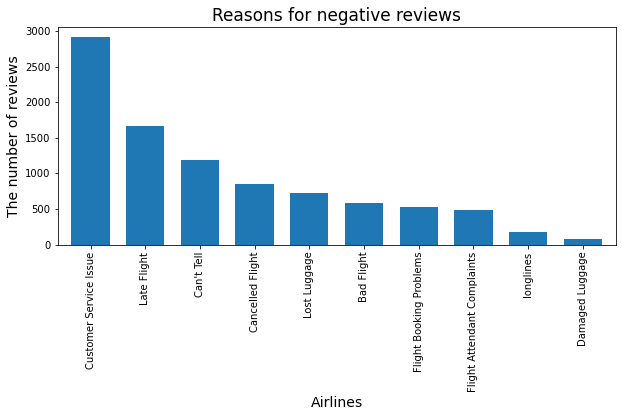

In [625]:
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 4
neg_reasons['airline_sentiment'].plot(kind = 'bar', width = 0.7)
plt.title("Reasons for negative reviews", fontsize= 17)
plt.xlabel("Airlines", fontsize = 14)
plt.ylabel("The number of reviews", fontsize = 14)

In [438]:
####################Going through the same vectorization process using sklearn then perform data modeling


In [569]:
######### United ##########
##For negative comments

import warnings
warnings.filterwarnings("ignore")

max_ngram_4 = 4

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt", 'w', 't', 'b', 'd','m', 'f']

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

# Vectorize using CountVectorier 

vectorizer6 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 2000
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram_4))

X3 = vectorizer6.fit_transform(df_neg_united['token'])  #X3 only included tokens from negative comments belonged to United airline
X3.shape

(2633, 1816)

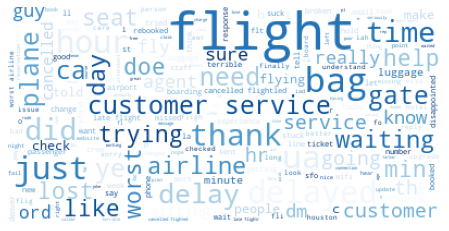

In [570]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', stopwords=stopwords, max_font_size=48, random_state=42,
               colormap='Blues')
wc.generate(df_neg_united['token'].to_string())
plt.imshow(wc)
plt.axis('off')
plt.show()

In [571]:
#Building the models with different numbers of topics for negative comments: 

#5 topics
lda_5_neg_united = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
topics_5_neg_united = lda_5_neg_united.fit_transform(X3)
#4 topics
lda_4_neg_united = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online')
topics_4_neg_united = lda_4_neg_united.fit_transform(X3)
#3 topics
lda_3_neg_united = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
topics_3_neg_united = lda_3_neg_united.fit_transform(X3)
#2 topics
lda_2_neg_united = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
topics_2_neg_united = lda_2_neg_united.fit_transform(X3)

In [572]:
# Check log-likelihood for negative comments for United 
print("5 Topics Log Likelihood for negative comments: ", lda_5_neg_united.score(X3))
print("4 Topics Log Likelihood for negative comments: ", lda_4_neg_united.score(X3))
print("3 Topics Log Likelihood for negative comments: ", lda_3_neg_united.score(X3))
print("2 Topics Log Likelihood for negative comments: ", lda_2_neg_united.score(X3))

5 Topics Log Likelihood for negative comments:  -155624.0674812869
4 Topics Log Likelihood for negative comments:  -153609.10638460898
3 Topics Log Likelihood for negative comments:  -152731.92354729783
2 Topics Log Likelihood for negative comments:  -151977.68707588338


In [573]:
#Check perplexity score of modles:
print("5 Topics perplexity for negative comments:", lda_5_neg_united.perplexity(X3))
print("4 Topics perplexity for negative comments:", lda_4_neg_united.perplexity(X3))
print("3 Topics perplexity for negative comments:", lda_3_neg_united.perplexity(X3))
print("2 Topics perplexity for negative comments:", lda_2_neg_united.perplexity(X3))

5 Topics perplexity for negative comments: 1128.2869206125501
4 Topics perplexity for negative comments: 1030.1441225426488
3 Topics perplexity for negative comments: 990.1314914150498
2 Topics perplexity for negative comments: 956.9720097080364


In [574]:
# Define Search Param for united 
search_params3 = {'n_components': [2, 3, 4, 5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model3 = GridSearchCV(lda, param_grid=search_params3)

# Do the Grid Search
model3.fit(X3)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [2, 3, 4, 5]})

In [575]:
## best model for topic modeling negative comments 
best_lda_neg_united = model3.best_estimator_
best_lda_neg_united 

LatentDirichletAllocation(n_components=2)

In [576]:
print("Grid scores on development set:")
means3 = model3.cv_results_['mean_test_score']
stds3 = model3.cv_results_['std_test_score']

for mean, std, params in zip(means3, stds3, model3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
-33973.920 (+/-970.138) for {'n_components': 2}
-35557.142 (+/-973.520) for {'n_components': 3}
-36898.854 (+/-923.893) for {'n_components': 4}
-38090.070 (+/-1070.716) for {'n_components': 5}


In [707]:
# Get the topics and n_top_words for 3 topics for negative comments for united and actually it is better! 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model3_neg_united = lda_3_neg_united
n_top_words3_neg_united = 10
topic_words3_neg_united = {}
vocab3_neg_united = vectorizer6.get_feature_names()

for topic, comp in enumerate(model3_neg_united.components_):  
    word_idx3_neg_united = np.argsort(comp)[::-1][:n_top_words3_neg_united]
    # store the words most relevant to the topic
    topic_words3_neg_united[topic] = [vocab3_neg_united[i] for i in word_idx3_neg_united]

for topic, word in topic_words3_neg_united.items():
    new_top3_neg_united = topic+1
    print('Topic: %d' % new_top3_neg_united)
    print('  %s' % ', '.join(word))

panel3_neg_united = LDAvis.prepare(lda_3_neg_united, X3, vectorizer6)
pyLDAvis.save_html(panel3_neg_united,'panel3_viz_neg_united.html')
panel3_neg_united

Topic: 1
  service, customer, customer service, thanks, like, just, help, know, need, did
Topic: 2
  flight, bag, plane, cancelled, hour, gate, time, amp, seat, late
Topic: 3
  flight, delay, hour, airline, delayed, ua, time, luggage, crew, worst


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.101124  0.180747       1        1  42.669424
2     -0.139223 -0.162605       2        1  29.625293
0      0.240347 -0.018142       3        1  27.705283, topic_info=                  Term        Freq       Total Category  logprob  loglift
582             flight  821.000000  821.000000  Default  30.0000  30.0000
1424           service  215.000000  215.000000  Default  29.0000  29.0000
359           customer  207.000000  207.000000  Default  28.0000  28.0000
363   customer service  119.000000  119.000000  Default  27.0000  27.0000
392              delay  124.000000  124.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
108                bag   47.797182  239.849086   Topic3  -4.8547  -0.3295
665                fly   33.405863   64.921255   Topic3  -5.2130   0.6191
375                day   37.834804  124.628235   Topic3  -5.0885   0.0914
1117               new   29.445215   42.458565   Topic3  -5.3392   0.9175
494              email   29.534220   51.177319   Topic3  -5.3361   0.7338

[179 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
21        1  0.756722          agent
21        3  0.237827          agent
30        1  0.218629        airline
30        2  0.607304        airline
30        3  0.178142        airline
...     ...       ...            ...
1783      2  0.963711          worse
1783      3  0.043805          worse
1784      2  0.827754          worst
1784      3  0.162837          worst
1785      2  0.945463  worst airline

[231 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [708]:
#Modeling 

#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model2_neg_united = lda_2_neg_united
n_top_words2_neg_united = 10
topic_words2_neg_united = {}
vocab2_neg_united = vectorizer6.get_feature_names()

for topic, comp in enumerate(model2_neg_united.components_):  
    word_idx2_neg_united = np.argsort(comp)[::-1][:n_top_words2_neg_united]
    # store the words most relevant to the topic
    topic_words2_neg_united[topic] = [vocab2_neg_united[i] for i in word_idx2_neg_united]

for topic, word in topic_words2_neg_united.items():
    new_top2_neg_united = topic+1
    print('Topic: %d' % new_top2_neg_united)
    print('  %s' % ', '.join(word))

panel2_neg_united = LDAvis.prepare(lda_2_neg_united, X3, vectorizer6)
pyLDAvis.save_html(panel2_neg_united,'panel2_viz_neg_united.html')
panel2_neg_united

Topic: 1
  flight, plane, ua, gate, bag, airline, hour, delayed, waiting, worst
Topic: 2
  flight, customer, service, just, cancelled, time, customer service, hour, late, bag


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.137237  0.0       1        1  50.869835
0     -0.137237  0.0       2        1  49.130165, topic_info=           Term        Freq       Total Category  logprob  loglift
359    customer  208.000000  208.000000  Default  30.0000  30.0000
1215      plane  188.000000  188.000000  Default  29.0000  29.0000
203   cancelled  156.000000  156.000000  Default  28.0000  28.0000
1663         ua  148.000000  148.000000  Default  27.0000  27.0000
707        gate  142.000000  142.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
375         day   59.452035  124.804922   Topic2  -5.2094  -0.0309
1717       wait   46.030612   69.792055   Topic2  -5.4652   0.2945
1596       time   67.396137  219.403529   Topic2  -5.0839  -0.4696
21        agent   49.717099   92.605727   Topic2  -5.3882   0.0887
1401       seat   52.722164  122.723154   Topic2  -5.3295  -0.1342

[136 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
21        1  0.464334          agent
21        2  0.539923          agent
30        1  0.008172        airline
30        2  0.996976        airline
48        1  0.704409            amp
...     ...       ...            ...
1765      1  0.022935           wifi
1765      2  0.986198           wifi
1784      1  0.041102          worst
1784      2  0.959055          worst
1785      2  0.953827  worst airline

[186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [579]:
######### US Airway ############

##For negative comments

import warnings
warnings.filterwarnings("ignore")

max_ngram_4 = 4

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt"]

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

# Vectorize using TFIDF (vectorizer 3) because it has the best performance 

vectorizer7 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 2000
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram_4))

X4 = vectorizer7.fit_transform(df_neg_USAir['token'])  #X4 only included tokens from negative comments belonged to US Airway airline
X4.shape


(2263, 1630)

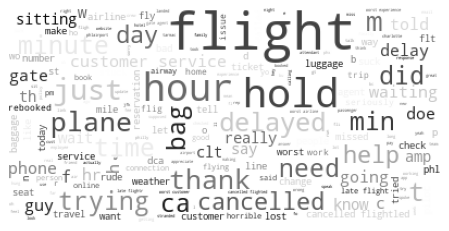

In [580]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', stopwords=stopwords, max_font_size=48, random_state=42,
               colormap='gray_r')
wc.generate(df_neg_USAir['token'].to_string())
plt.imshow(wc)
plt.axis('off')
plt.show()


In [581]:
#Building the models with different numbers of topics for negative comments: 

#5 topics
lda_5_neg_USAir = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
topics_5_neg_USAir = lda_5_neg_USAir.fit_transform(X4)
#4 topics
lda_4_neg_USAir = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online')
topics_4_neg_USAir = lda_4_neg_USAir.fit_transform(X4)
#3 topics
lda_3_neg_USAir = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
topics_3_neg_USAir = lda_3_neg_USAir.fit_transform(X4)
#2 topics
lda_2_neg_USAir = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
topics_2_neg_USAir = lda_2_neg_USAir.fit_transform(X4)


In [481]:
# Check log-likelihood for negative comments for United 
print("5 Topics Log Likelihood for negative comments: ", lda_5_neg_USAir.score(X4))
print("4 Topics Log Likelihood for negative comments: ", lda_4_neg_USAir.score(X4))
print("3 Topics Log Likelihood for negative comments: ", lda_3_neg_USAir.score(X4))
print("2 Topics Log Likelihood for negative comments: ", lda_2_neg_USAir.score(X4))

5 Topics Log Likelihood for negative comments:  -42434.972852840525
4 Topics Log Likelihood for negative comments:  -41538.48557500789
3 Topics Log Likelihood for negative comments:  -40408.83583950326
2 Topics Log Likelihood for negative comments:  -38946.42133877056


In [482]:
#Check perplexity score of modles:
print("5 Topics perplexity for negative comments:", lda_5_neg_USAir.perplexity(X4))
print("4 Topics perplexity for negative comments:", lda_4_neg_USAir.perplexity(X4))
print("3 Topics perplexity for negative comments:", lda_3_neg_USAir.perplexity(X4))
print("2 Topics perplexity for negative comments:", lda_2_neg_USAir.perplexity(X4))

5 Topics perplexity for negative comments: 1657.1743913000194
4 Topics perplexity for negative comments: 1416.9527950272134
3 Topics perplexity for negative comments: 1163.1975181296882
2 Topics perplexity for negative comments: 900.9611136481838


In [483]:
# Define Search Param for united 
search_params4 = {'n_components': [2, 3, 4, 5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model4 = GridSearchCV(lda, param_grid=search_params4)

# Do the Grid Search
model4.fit(X4)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [2, 3, 4, 5]})

In [582]:
## best model for topic modeling negative comments 
best_lda_neg_USAir = model4.best_estimator_
best_lda_neg_USAir 

LatentDirichletAllocation(n_components=2)

In [583]:
print("Grid scores on development set:")
means4 = model4.cv_results_['mean_test_score']
stds4 = model4.cv_results_['std_test_score']

for mean, std, params in zip(means4, stds4, model4.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
-8917.859 (+/-218.138) for {'n_components': 2}
-9662.506 (+/-205.459) for {'n_components': 3}
-10314.956 (+/-198.861) for {'n_components': 4}
-10855.035 (+/-215.471) for {'n_components': 5}


In [709]:
# Get the topics and n_top_words for 3 topics for negative comments for united and actually it is better! 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model3_neg_USAir = lda_3_neg_USAir
n_top_words3_neg_USAir = 10
topic_words3_neg_USAir = {}
vocab3_neg_USAir = vectorizer7.get_feature_names()

for topic, comp in enumerate(model3_neg_USAir.components_):  
    word_idx3_neg_USAir = np.argsort(comp)[::-1][:n_top_words3_neg_USAir]
    # store the words most relevant to the topic
    topic_words3_neg_USAir[topic] = [vocab3_neg_USAir[i] for i in word_idx3_neg_USAir]

for topic, word in topic_words3_neg_USAir.items():
    new_top3_neg_USAir = topic+1
    print('Topic: %d' % new_top3_neg_USAir)
    print('  %s' % ', '.join(word))

panel3_neg_USAir = LDAvis.prepare(lda_3_neg_USAir, X4, vectorizer7)
pyLDAvis.save_html(panel3_neg_USAir,'panel3_viz_neg_USAir.html')
panel3_neg_USAir

Topic: 1
  flight, hold, hour, time, service, customer, help, delayed, need, minute
Topic: 2
  day, bag, customer, service, luggage, phone, people, doe, say, customer service
Topic: 3
  flight, cancelled, plane, flightled, cancelled flightled, delay, mile, sitting, flight cancelled, hour


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.023740 -0.179197       1        1  44.547728
2     -0.188829  0.105496       2        1  29.007732
1      0.212569  0.073701       3        1  26.444540, topic_info=           Term        Freq       Total Category  logprob  loglift
479      flight  769.000000  769.000000  Default  30.0000  30.0000
678        hold  244.000000  244.000000  Default  29.0000  29.0000
318         day  119.000000  119.000000  Default  28.0000  28.0000
172   cancelled  190.000000  190.000000  Default  27.0000  27.0000
542   flightled   97.000000   97.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
712        hour   43.987438  297.810616   Topic3  -4.7638  -0.5824
363         did   28.935263   74.772188   Topic3  -5.1826   0.3807
811        know   25.446465   49.721727   Topic3  -5.3111   0.6603
1432       time   29.052084  167.626181   Topic3  -5.1786  -0.4225
663        help   27.338586  162.353607   Topic3  -5.2394  -0.4514

[189 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
9         2  0.967771                 account
9         3  0.053765                 account
23        1  0.750348                   agent
23        2  0.245568                   agent
31        1  0.424129                 airline
...     ...       ...                     ...
1601      1  0.985420                   worst
1603      1  0.957482          worst customer
1604      1  0.957482  worst customer service
1612      2  0.951314                   wrong
1612      3  0.045301                   wrong

[233 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [710]:
# Get the topics and n_top_words for 3 topics for negative comments for united and actually it is better! 
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model2_neg_USAir = lda_2_neg_USAir
n_top_words2_neg_USAir = 10
topic_words2_neg_USAir = {}
vocab2_neg_USAir = vectorizer7.get_feature_names()

for topic, comp in enumerate(model2_neg_USAir.components_):  
    word_idx2_neg_USAir = np.argsort(comp)[::-1][:n_top_words2_neg_USAir]
    # store the words most relevant to the topic
    topic_words2_neg_USAir[topic] = [vocab2_neg_USAir[i] for i in word_idx2_neg_USAir]

for topic, word in topic_words2_neg_USAir.items():
    new_top2_neg_USAir = topic+1
    print('Topic: %d' % new_top2_neg_USAir)
    print('  %s' % ', '.join(word))

panel2_neg_USAir = LDAvis.prepare(lda_2_neg_USAir, X4, vectorizer7)
pyLDAvis.save_html(panel2_neg_USAir,'panel2_viz_neg_USAir.html')
panel2_neg_USAir

Topic: 1
  flight, cancelled, time, hour, hold, flightled, cancelled flightled, just, service, customer
Topic: 2
  flight, hour, plane, hold, service, customer, help, customer service, late, gate


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.127058  0.0       1        1  55.228716
0     -0.127058  0.0       2        1  44.771284, topic_info=                     Term        Freq       Total Category  logprob  loglift
1103                plane  151.000000  151.000000  Default  30.0000  30.0000
542             flightled   97.000000   97.000000  Default  29.0000  29.0000
183   cancelled flightled   96.000000   96.000000  Default  28.0000  28.0000
822                  late   97.000000   97.000000  Default  27.0000  27.0000
847                  like   56.000000   56.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
31                airline   39.320661   80.062123   Topic2  -5.4025   0.0926
1540              waiting   39.960044   88.026415   Topic2  -5.3863   0.0138
332                 delay   38.120884   82.861340   Topic2  -5.4334   0.0272
944                   min   38.514926  107.837780   Topic2  -5.4232  -0.2260
1419               thanks   37.150325   76.140534   Topic2  -5.4592   0.0860

[144 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
9         1  0.053738                 account
9         2  0.967285                 account
31        1  0.512102                 airline
31        2  0.487122                 airline
34        1  0.927416                 airport
...     ...       ...                     ...
1594      2  0.024771                    work
1603      1  0.953664          worst customer
1603      2  0.052981          worst customer
1604      1  0.953664  worst customer service
1604      2  0.052981  worst customer service

[199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [588]:
###### American Airline (5)#######
##For negative comments

import warnings
warnings.filterwarnings("ignore")

max_ngram_4 = 4

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt", 'm', 't']

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

# Vectorize 8 for AA using TFIDF because it has the best performance 

vectorizer8 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 2000
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram_4))

X5 = vectorizer8.fit_transform(df_neg_AA['token'])  #X5 only included tokens from negative comments belonged to AA
X5.shape

(1960, 1460)

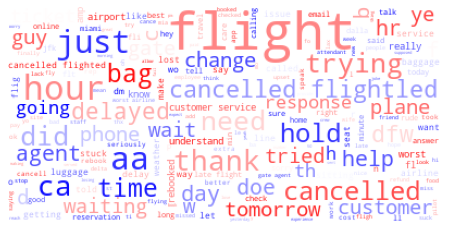

In [589]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', stopwords=stopwords, max_font_size=48, random_state=42,
               colormap='bwr')
wc.generate(df_neg_AA['token'].to_string())
plt.imshow(wc)
plt.axis('off')
plt.show()

In [590]:
#Building the models with different numbers of topics for negative comments: 

#5 topics
lda_5_neg_AA = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
topics_5_neg_AA = lda_5_neg_AA.fit_transform(X5)
#4 topics
lda_4_neg_AA = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online')
topics_4_neg_AA = lda_4_neg_AA.fit_transform(X5)
#3 topics
lda_3_neg_AA = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
topics_3_neg_AA = lda_3_neg_AA.fit_transform(X5)
#2 topics
lda_2_neg_AA = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
topics_2_neg_AA = lda_2_neg_AA.fit_transform(X5)

In [591]:
# Check log-likelihood for negative comments for AA
print("5 Topics Log Likelihood for negative comments: ", lda_5_neg_AA.score(X5))
print("4 Topics Log Likelihood for negative comments: ", lda_4_neg_AA.score(X5))
print("3 Topics Log Likelihood for negative comments: ", lda_3_neg_AA.score(X5))
print("2 Topics Log Likelihood for negative comments: ", lda_2_neg_AA.score(X5))

5 Topics Log Likelihood for negative comments:  -112391.8077289665
4 Topics Log Likelihood for negative comments:  -111503.25749697517
3 Topics Log Likelihood for negative comments:  -111560.24354035658
2 Topics Log Likelihood for negative comments:  -110511.2930399489


In [592]:
#Check perplexity score of models for AA
print("5 Topics perplexity for negative comments:", lda_5_neg_AA.perplexity(X5))
print("4 Topics perplexity for negative comments:", lda_4_neg_AA.perplexity(X5))
print("3 Topics perplexity for negative comments:", lda_3_neg_AA.perplexity(X5))
print("2 Topics perplexity for negative comments:", lda_2_neg_AA.perplexity(X5))

5 Topics perplexity for negative comments: 852.5503135954311
4 Topics perplexity for negative comments: 808.2584466768902
3 Topics perplexity for negative comments: 811.0286861477424
2 Topics perplexity for negative comments: 761.5244717114895


In [593]:
# Define Search Param for AA
search_params5 = {'n_components': [2, 3, 4, 5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model5 = GridSearchCV(lda, param_grid=search_params5)

# Do the Grid Search
model5.fit(X5)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [2, 3, 4, 5]})

In [594]:
## best model for topic modeling negative comments 
best_lda_neg_AA = model5.best_estimator_
best_lda_neg_AA 

LatentDirichletAllocation(n_components=2)

In [595]:
print("Grid scores on development set:")
means5 = model5.cv_results_['mean_test_score']
stds5 = model5.cv_results_['std_test_score']

for mean, std, params in zip(means5, stds5, model5.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
-25123.134 (+/-1009.566) for {'n_components': 2}
-26268.478 (+/-996.968) for {'n_components': 3}
-27363.944 (+/-1158.169) for {'n_components': 4}
-28246.646 (+/-1226.266) for {'n_components': 5}


In [711]:
# Get the topics and n_top_words for 3 topics for negative comments for AA and showed slightly differences with United (weather, customer service phone)
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model3_neg_AA = lda_3_neg_AA
n_top_words3_neg_AA = 10
topic_words3_neg_AA = {}
vocab3_neg_AA = vectorizer8.get_feature_names()

for topic, comp in enumerate(model3_neg_AA.components_):  
    word_idx3_neg_AA = np.argsort(comp)[::-1][:n_top_words3_neg_AA]
    # store the words most relevant to the topic
    topic_words3_neg_AA[topic] = [vocab3_neg_AA[i] for i in word_idx3_neg_AA]

for topic, word in topic_words3_neg_AA.items():
    new_top3_neg_AA = topic+1
    print('Topic: %d' % new_top3_neg_AA)
    print('  %s' % ', '.join(word))

panel3_neg_AA = LDAvis.prepare(lda_3_neg_AA, X5, vectorizer8)
pyLDAvis.save_html(panel3_neg_AA,'panel3_viz_neg_AA.html')
panel3_neg_AA

Topic: 1
  flight, cancelled, did, ca, seat, help, just, flighted, cancelled flighted, hold
Topic: 2
  service, hour, customer, agent, customer service, gate, time, bag, phone, hold
Topic: 3
  flight, cancelled, flightled, cancelled flightled, hour, aa, late, dfw, flight cancelled, delayed


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.184684 -0.108760       1        1  34.467444
2     -0.201372 -0.083789       2        1  32.928484
0      0.016689  0.192548       3        1  32.604072, topic_info=                     Term        Freq       Total Category  logprob  loglift
482                flight  650.000000  650.000000  Default  30.0000  30.0000
546             flightled  137.000000  137.000000  Default  29.0000  29.0000
187   cancelled flightled  136.000000  136.000000  Default  28.0000  28.0000
176             cancelled  274.000000  274.000000  Default  27.0000  27.0000
1159              service  143.000000  143.000000  Default  26.0000  26.0000
...                   ...         ...         ...      ...      ...      ...
975                people   30.599018   45.718125   Topic3  -5.1788   0.7192
327                   day   41.818640   99.109876   Topic3  -4.8664   0.2578
1292                 told   30.550573   48.660944   Topic3  -5.1803   0.6552
1295             tomorrow   35.938545   86.663488   Topic3  -5.0179   0.2405
982                 phone   32.892540  114.543014   Topic3  -5.1065  -0.1270

[192 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.340858     aa
0         2  0.499114     aa
0         3  0.158256     aa
31        1  0.779885  agent
31        2  0.018569  agent
...     ...       ...    ...
1430      1  0.022802   work
1430      3  0.957684   work
1437      1  0.844132  worst
1437      2  0.148964  worst
1446      3  0.951351  wrong

[246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [712]:
#2 topics for aa
model2_neg_AA = lda_2_neg_AA
n_top_words2_neg_AA = 10
topic_words2_neg_AA = {}
vocab2_neg_AA = vectorizer8.get_feature_names()

for topic, comp in enumerate(model2_neg_AA.components_):  
    word_idx2_neg_AA = np.argsort(comp)[::-1][:n_top_words2_neg_AA]
    # store the words most relevant to the topic
    topic_words2_neg_AA[topic] = [vocab3_neg_AA[i] for i in word_idx2_neg_AA]

for topic, word in topic_words2_neg_AA.items():
    new_top2_neg_AA = topic+1
    print('Topic: %d' % new_top2_neg_AA)
    print('  %s' % ', '.join(word))

panel2_neg_AA = LDAvis.prepare(lda_2_neg_AA, X5, vectorizer8)
pyLDAvis.save_html(panel2_neg_AA,'panel2_viz_neg_AA.html')
panel2_neg_AA

Topic: 1
  flight, cancelled, flightled, cancelled flightled, help, service, ca, customer, tomorrow, phone
Topic: 2
  flight, hour, time, aa, plane, hr, waiting, late, just, gate


PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
0      0.14466  0.0       1        1  51.346261
1     -0.14466  0.0       2        1  48.653739, topic_info=                    Term        Freq       Total Category  logprob  loglift
176            cancelled  275.000000  275.000000  Default  30.0000  30.0000
546            flightled  138.000000  138.000000  Default  29.0000  29.0000
187  cancelled flightled  137.000000  137.000000  Default  28.0000  28.0000
482               flight  654.000000  654.000000  Default  27.0000  27.0000
997                plane   98.000000   98.000000  Default  26.0000  26.0000
..                   ...         ...         ...      ...      ...      ...
660                 hold   52.467831  122.506703   Topic2  -5.0398  -0.1275
57                   amp   46.616269   96.164875   Topic2  -5.1581  -0.0037
310             customer   51.259303  159.021904   Topic2  -5.0631  -0.4117
31                 agent   39.977235  106.667084   Topic2  -5.3117  -0.2610
912                 need   39.136473  113.430834   Topic2  -5.3330  -0.3437

[138 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.328456         aa
0         2  0.669076         aa
31        1  0.628123      agent
31        2  0.374999      agent
37        1  0.059456        ago
...     ...       ...        ...
1410      2  0.965714       week
1430      1  0.045102       work
1430      2  0.969695       work
1456      1  0.968667  yesterday
1456      2  0.033402  yesterday

[183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [602]:
###### Southwest (6)#######
##For negative comments

import warnings
warnings.filterwarnings("ignore")

max_ngram_4 = 4

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt"]

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

# Vectorize 8 for AA using TFIDF because it has the best performance 

vectorizer9 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 2000
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram_4))

X6 = vectorizer9.fit_transform(df_neg_SW['token'])  #X5 only included tokens from negative comments belonged to AA
X6.shape

(1186, 940)

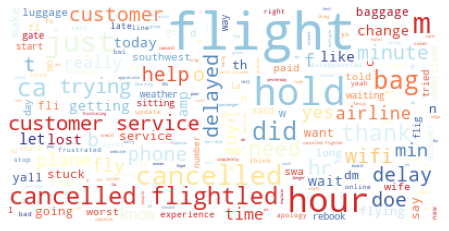

In [603]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', stopwords=stopwords, max_font_size=48, random_state=42,
               colormap='RdYlBu')
wc.generate(df_neg_SW['token'].to_string())
plt.imshow(wc)
plt.axis('off')
plt.show()

In [604]:
#Building the models with different numbers of topics for negative comments for SouthWest: 

#5 topics
lda_5_neg_SW = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
topics_5_neg_SW = lda_5_neg_SW.fit_transform(X6)
#4 topics
lda_4_neg_SW = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online')
topics_4_neg_SW = lda_4_neg_SW.fit_transform(X6)
#3 topics
lda_3_neg_SW = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
topics_3_neg_SW = lda_3_neg_SW.fit_transform(X6)
#2 topics
lda_2_neg_SW = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
topics_2_neg_SW = lda_2_neg_SW.fit_transform(X6)

In [605]:
# Check log-likelihood for negative comments for SW
print("5 Topics Log Likelihood for negative comments: ", lda_5_neg_SW.score(X6))
print("4 Topics Log Likelihood for negative comments: ", lda_4_neg_SW.score(X6))
print("3 Topics Log Likelihood for negative comments: ", lda_3_neg_SW.score(X6))
print("2 Topics Log Likelihood for negative comments: ", lda_2_neg_SW.score(X6))

5 Topics Log Likelihood for negative comments:  -60229.720913078854
4 Topics Log Likelihood for negative comments:  -60229.74443897221
3 Topics Log Likelihood for negative comments:  -59922.27923490198
2 Topics Log Likelihood for negative comments:  -59550.26441424289


In [606]:
#Check perplexity score of models for SW
print("5 Topics perplexity for negative comments:", lda_5_neg_SW.perplexity(X6))
print("4 Topics perplexity for negative comments:", lda_4_neg_SW.perplexity(X6))
print("3 Topics perplexity for negative comments:", lda_3_neg_SW.perplexity(X6))
print("2 Topics perplexity for negative comments:", lda_2_neg_SW.perplexity(X6))

5 Topics perplexity for negative comments: 618.8926262259448
4 Topics perplexity for negative comments: 618.8941801235114
3 Topics perplexity for negative comments: 598.9154977727105
2 Topics perplexity for negative comments: 575.6027544319102


In [607]:
# Define Search Param for SW
search_params6 = {'n_components': [2, 3, 4, 5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model6 = GridSearchCV(lda, param_grid=search_params6)

# Do the Grid Search
model6.fit(X6)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [2, 3, 4, 5]})

In [608]:
## best model for topic modeling negative comments 
best_lda_neg_SW = model6.best_estimator_
best_lda_neg_SW 

LatentDirichletAllocation(n_components=2)

In [609]:
print("Grid scores on development set:")
means6 = model6.cv_results_['mean_test_score']
stds6 = model6.cv_results_['std_test_score']

for mean, std, params in zip(means6, stds6, model6.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
-13640.391 (+/-1365.328) for {'n_components': 2}
-14404.547 (+/-1359.978) for {'n_components': 3}
-15071.652 (+/-1516.839) for {'n_components': 4}
-15618.222 (+/-1464.244) for {'n_components': 5}


In [713]:
# Get the topics and n_top_words for 3 topics for negative comments for SW and showed slightly differences with United (weather, customer service phone)
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
# Get the topics and n_top_words for 3 topics for negative comments for SW and showed slightly differences with United (weather, customer service phone)
#https://stackoverflow.com/questions/44208501/getting-topic-word-distribution-from-lda-in-scikit-learn
model3_neg_SW = lda_3_neg_SW
n_top_words3_neg_SW = 10
topic_words3_neg_SW = {}
vocab3_neg_SW = vectorizer9.get_feature_names()

for topic, comp in enumerate(model3_neg_SW.components_):  
    word_idx3_neg_SW = np.argsort(comp)[::-1][:n_top_words3_neg_SW]
    # store the words most relevant to the topic
    topic_words3_neg_SW[topic] = [vocab3_neg_SW[i] for i in word_idx3_neg_SW]

for topic, word in topic_words3_neg_SW.items():
    new_top3_neg_SW = topic+1
    print('Topic: %d' % new_top3_neg_SW)
    print('  %s' % ', '.join(word))

panel3_neg_SW = LDAvis.prepare(lda_3_neg_SW, X6, vectorizer9)
pyLDAvis.save_html(panel3_neg_SW,'panel3_viz_neg_SW.html')
panel3_neg_SW

Topic: 1
  flight, cancelled, cancelled flightled, flightled, hold, flight cancelled, hr, flight cancelled flightled, time, cancelled flightled flight
Topic: 2
  hour, hold, flight, phone, help, ca, online, trying, hold hour, just
Topic: 3
  customer, service, customer service, bag, hour, flight, plane, gate, late, seat


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.025602 -0.188187       1        1  37.031322
2     -0.191388  0.073859       2        1  31.794317
1      0.165785  0.114328       3        1  31.174360, topic_info=                    Term        Freq       Total Category  logprob  loglift
105            cancelled  189.000000  189.000000  Default  30.0000  30.0000
745              service   86.000000   86.000000  Default  29.0000  29.0000
116  cancelled flightled   97.000000   97.000000  Default  28.0000  28.0000
338            flightled   97.000000   97.000000  Default  27.0000  27.0000
189             customer  103.000000  103.000000  Default  26.0000  26.0000
..                   ...         ...         ...      ...      ...      ...
707          reservation   14.659555   21.142792   Topic3  -5.2946   0.7994
830                 time   22.032351   88.736937   Topic3  -4.8872  -0.2276
891                 wait   16.115623   36.584741   Topic3  -5.1999   0.3457
777            southwest   14.793076   23.000563   Topic3  -5.2855   0.7242
222                  did   15.492156   42.858029   Topic3  -5.2394   0.1480

[186 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
0         2  0.947401                    able
0         3  0.086127                    able
11        1  0.038836                   agent
11        2  0.970902                   agent
14        1  0.083409                     ago
...     ...       ...                     ...
925       1  0.278801                   worst
925       2  0.716917                   worst
927       2  0.915615          worst customer
928       2  0.915617  worst customer service
934       1  0.910968                    yeah

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [714]:
model2_neg_SW = lda_2_neg_SW
n_top_words2_neg_SW = 10
topic_words2_neg_SW = {}
vocab2_neg_SW = vectorizer9.get_feature_names()

for topic, comp in enumerate(model2_neg_SW.components_):  
    word_idx2_neg_SW = np.argsort(comp)[::-1][:n_top_words2_neg_SW]
    # store the words most relevant to the topic
    topic_words2_neg_SW[topic] = [vocab2_neg_SW[i] for i in word_idx2_neg_SW]

for topic, word in topic_words2_neg_SW.items():
    new_top2_neg_SW = topic+1
    print('Topic: %d' % new_top2_neg_SW)
    print('  %s' % ', '.join(word))

panel2_neg_SW = LDAvis.prepare(lda_2_neg_SW, X6, vectorizer9)
pyLDAvis.save_html(panel2_neg_SW,'panel2_viz_neg_SW.html')
panel2_neg_SW

Topic: 1
  hour, flight, customer, hold, service, just, bag, customer service, time, hr
Topic: 2
  flight, cancelled, flightled, cancelled flightled, hold, help, flight cancelled, ca, online, phone


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.137567  0.0       1        1  50.641534
1     -0.137567  0.0       2        1  49.358466, topic_info=                    Term        Freq       Total Category  logprob  loglift
105            cancelled  184.000000  184.000000  Default  30.0000  30.0000
292               flight  430.000000  430.000000  Default  29.0000  29.0000
338            flightled   95.000000   95.000000  Default  28.0000  28.0000
116  cancelled flightled   95.000000   95.000000  Default  27.0000  27.0000
745              service   85.000000   85.000000  Default  26.0000  26.0000
..                   ...         ...         ...      ...      ...      ...
830                 time   38.188705   88.700269   Topic2  -4.7967  -0.1367
428                 hour   39.877629  171.999832   Topic2  -4.7534  -0.7556
414            hold hour   27.616773   60.230791   Topic2  -5.1208  -0.0737
199                  day   24.956689   44.383979   Topic2  -5.2221   0.1303
576                 need   23.808063   51.473025   Topic2  -5.2692  -0.0650

[135 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
11        1  0.081014    agent
11        2  0.931664    agent
17        1  0.021323  airline
17        2  0.980838  airline
20        1  0.848242  airport
...     ...       ...      ...
919       2  0.980366       wo
922       1  0.937245     work
922       2  0.046862     work
933       1  0.075317     yall
933       2  0.979115     yall

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [735]:
########Delta###### 
##For negative comments

import warnings
warnings.filterwarnings("ignore")

max_ngram_4 = 4

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt"]

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

# Vectorize 10 for Delta using TFIDF because it has the best performance 

vectorizer10 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 2000
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram_4))

X7 = vectorizer10.fit_transform(df_neg_Delta['token'])  #X5 only included tokens from negative comments belonged to AA
X7.shape

(955, 690)

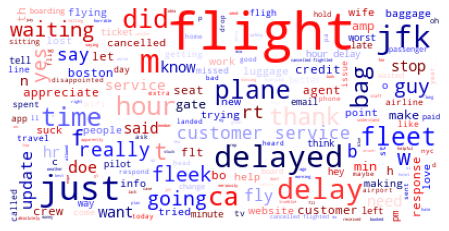

In [736]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', stopwords=stopwords, max_font_size=48, random_state=42,
               colormap='seismic')
wc.generate(df_neg_Delta['token'].to_string())
plt.imshow(wc)
plt.axis('off')
plt.show()

In [737]:
#Building the models with different numbers of topics for negative comments for SouthWest: 

#5 topics
lda_5_neg_Delta = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
topics_5_neg_Delta = lda_5_neg_Delta.fit_transform(X7)
#4 topics
lda_4_neg_Delta = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online')
topics_4_neg_Delta = lda_4_neg_Delta.fit_transform(X7)
#3 topics
lda_3_neg_Delta = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
topics_3_neg_Delta = lda_3_neg_Delta.fit_transform(X7)
#2 topics
lda_2_neg_Delta = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
topics_2_neg_Delta = lda_2_neg_Delta.fit_transform(X7)

In [ ]:
# Check log-likelihood for negative comments for Delta
print("5 Topics Log Likelihood for negative comments: ", lda_5_neg_Delta.score(X7))
print("4 Topics Log Likelihood for negative comments: ", lda_4_neg_Delta.score(X7))
print("3 Topics Log Likelihood for negative comments: ", lda_3_neg_Delta.score(X7))
print("2 Topics Log Likelihood for negative comments: ", lda_2_neg_Delta.score(X7))

In [ ]:
#Check perplexity score of models for Delta
print("5 Topics perplexity for negative comments:", lda_5_neg_Delta.perplexity(X7))
print("4 Topics perplexity for negative comments:", lda_4_neg_Delta.perplexity(X7))
print("3 Topics perplexity for negative comments:", lda_3_neg_Delta.perplexity(X7))
print("2 Topics perplexity for negative comments:", lda_2_neg_Delta.perplexity(X7))

In [ ]:
# Define Search Param for Delta
search_params7 = {'n_components': [2, 3, 4, 5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model7 = GridSearchCV(lda, param_grid=search_params7)

# Do the Grid Search
model7.fit(X7)

In [738]:
## best model for topic modeling negative comments 
best_lda_neg_Delta = model7.best_estimator_
best_lda_neg_Delta 

LatentDirichletAllocation(n_components=2)

In [739]:
print("Grid scores on development set:")
means7 = model7.cv_results_['mean_test_score']
stds7 = model7.cv_results_['std_test_score']

for mean, std, params in zip(means7, stds7, model7.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
-9247.153 (+/-608.542) for {'n_components': 2}
-9837.122 (+/-585.978) for {'n_components': 3}
-10326.301 (+/-666.450) for {'n_components': 4}
-10765.560 (+/-713.460) for {'n_components': 5}


In [740]:
model3_neg_Delta = lda_3_neg_Delta
n_top_words3_neg_Delta = 10
topic_words3_neg_Delta = {}
vocab3_neg_Delta = vectorizer10.get_feature_names()

for topic, comp in enumerate(model3_neg_Delta.components_):  
    word_idx3_neg_Delta = np.argsort(comp)[::-1][:n_top_words3_neg_Delta]
    # store the words most relevant to the topic
    topic_words3_neg_Delta[topic] = [vocab3_neg_Delta[i] for i in word_idx3_neg_Delta]

for topic, word in topic_words3_neg_Delta.items():
    new_top3_neg_Delta = topic+1
    print('Topic: %d' % new_top3_neg_Delta)
    print('  %s' % ', '.join(word))

panel3_neg_Delta = LDAvis.prepare(lda_3_neg_Delta, X7, vectorizer10)
pyLDAvis.save_html(panel3_neg_Delta,'panel3_viz_neg_Delta.html')
panel3_neg_Delta

Topic: 1
  flight, did, ca, ticket, want, delay, say, said, amp, issue
Topic: 2
  customer, service, flight, cancelled, customer service, help, amp, need, doe, baggage
Topic: 3
  flight, hour, delayed, time, plane, just, jfk, bag, delay, waiting


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.175973 -0.097698       1        1  43.729618
1     -0.178559 -0.093515       2        1  31.143727
0      0.002586  0.191213       3        1  25.126654, topic_info=         Term       Freq      Total Category  logprob  loglift
136  customer  53.000000  53.000000  Default  30.0000  30.0000
537   service  51.000000  51.000000  Default  29.0000  29.0000
307      hour  87.000000  87.000000  Default  28.0000  28.0000
470     plane  62.000000  62.000000  Default  27.0000  27.0000
146   delayed  77.000000  77.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
18        amp  17.201807  52.743372   Topic3  -4.5197   0.2608
608      told  11.441289  22.731696   Topic3  -4.9275   0.6947
9       agent  10.633997  17.452286   Topic3  -5.0006   0.8858
14    airport  11.919104  33.210137   Topic3  -4.8865   0.3565
530      seat  11.284552  26.805092   Topic3  -4.9412   0.5161

[166 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5         2  0.945901  account
9         1  0.286495    agent
9         2  0.114598    agent
9         3  0.630290    agent
13        2  0.906952  airline
...     ...       ...      ...
676       1  0.941529  working
678       2  0.964417    worst
685       1  0.054219      yes
685       2  0.162657      yes
685       3  0.759067      yes

[205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [741]:
model2_neg_Delta = lda_2_neg_Delta
n_top_words2_neg_Delta = 10
topic_words2_neg_Delta = {}
vocab2_neg_Delta = vectorizer10.get_feature_names()

for topic, comp in enumerate(model2_neg_Delta.components_):  
    word_idx2_neg_Delta = np.argsort(comp)[::-1][:n_top_words2_neg_Delta]
    # store the words most relevant to the topic
    topic_words2_neg_Delta[topic] = [vocab2_neg_Delta[i] for i in word_idx2_neg_Delta]

for topic, word in topic_words2_neg_Delta.items():
    new_top2_neg_Delta = topic+1
    print('Topic: %d' % new_top2_neg_Delta)
    print('  %s' % ', '.join(word))

panel2_neg_Delta = LDAvis.prepare(lda_2_neg_Delta, X7, vectorizer10)
pyLDAvis.save_html(panel2_neg_Delta,'panel2_viz_neg_Delta.html')
panel2_neg_Delta

Topic: 1
  flight, delayed, time, hour, delay, jfk, plane, just, amp, cancelled
Topic: 2
  customer, service, bag, customer service, help, ca, did, just, guy, need


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.151973  0.0       1        1  57.337622
1     -0.151973  0.0       2        1  42.662378, topic_info=         Term        Freq       Total Category  logprob  loglift
209    flight  322.000000  322.000000  Default  30.0000  30.0000
136  customer   54.000000   54.000000  Default  29.0000  29.0000
537   service   52.000000   52.000000  Default  28.0000  28.0000
146   delayed   76.000000   76.000000  Default  27.0000  27.0000
603      time   74.000000   74.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
653   waiting   23.271755   36.983852   Topic2  -4.7468   0.3886
165       doe   16.832757   21.972416   Topic2  -5.0707   0.5854
341      just   27.209179   75.974503   Topic2  -4.5905  -0.1750
657      want   15.389624   20.993725   Topic2  -5.1604   0.5413
524       say   14.924373   25.926902   Topic2  -5.1911   0.2996

[131 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9         2  0.976518    agent
14        1  0.726381  airport
14        2  0.302659  airport
18        1  0.771175      amp
18        2  0.225710      amp
...     ...       ...      ...
676       1  0.086902  working
676       2  0.955925  working
678       1  0.071845    worst
678       2  0.933987    worst
683       2  0.943325     year

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

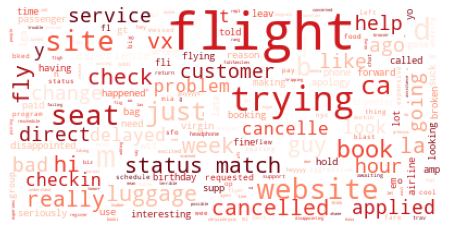

In [733]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', stopwords=stopwords, max_font_size=48, random_state=42,
               colormap='Reds')
wc.generate(df_neg_VA['token'].to_string())
plt.imshow(wc)
plt.axis('off')
plt.show()

In [635]:
import warnings
warnings.filterwarnings("ignore")

max_ngram_4 = 4

#   SETUP customized stopwords:
additional_stopwords = ['english', 'southwestair', 'usairways', 'americanair', 'jetblue', 'virginamerica','united', "get","got", "u", "s", "wa", "would", "could", "might", "ha", "ve", "nt"]

#Extend our stopwords list:  
stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

# Vectorize 10 for Delta using TFIDF because it has the best performance 

vectorizer11 = CountVectorizer(encoding      = 'latin-1'
                              , binary      = False
                              , min_df      = 3
                              , max_df      = 2000
                              , stop_words  = stopwords
                              , ngram_range = (1, max_ngram_4))

X8 = vectorizer11.fit_transform(df_neg_VA['token'])  #X5 only included tokens from negative comments belonged to AA
X8.shape

(181, 157)

In [636]:
#Building the models with different numbers of topics for negative comments for Virgin America: 

#5 topics
lda_5_neg_VA = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online')
topics_5_neg_VA = lda_5_neg_VA.fit_transform(X8)
#4 topics
lda_4_neg_VA = LatentDirichletAllocation(n_components=4, max_iter=10, learning_method='online')
topics_4_neg_VA = lda_4_neg_VA.fit_transform(X8)
#3 topics
lda_3_neg_VA = LatentDirichletAllocation(n_components=3, max_iter=10, learning_method='online')
topics_3_neg_VA = lda_3_neg_VA.fit_transform(X8)
#2 topics
lda_2_neg_VA = LatentDirichletAllocation(n_components=2, max_iter=10, learning_method='online')
topics_2_neg_VA = lda_2_neg_VA.fit_transform(X8)

In [637]:
# Check log-likelihood for negative comments for Delta
print("5 Topics Log Likelihood for negative comments: ", lda_5_neg_VA.score(X8))
print("4 Topics Log Likelihood for negative comments: ", lda_4_neg_VA.score(X8))
print("3 Topics Log Likelihood for negative comments: ", lda_3_neg_VA.score(X8))
print("2 Topics Log Likelihood for negative comments: ", lda_2_neg_VA.score(X8))

5 Topics Log Likelihood for negative comments:  -4968.751971007228
4 Topics Log Likelihood for negative comments:  -4947.953020378125
3 Topics Log Likelihood for negative comments:  -4853.008117002017
2 Topics Log Likelihood for negative comments:  -4744.561765303189


In [638]:
#Check perplexity score of models for va
print("5 Topics perplexity for negative comments:", lda_5_neg_VA.perplexity(X8))
print("4 Topics perplexity for negative comments:", lda_4_neg_VA.perplexity(X8))
print("3 Topics perplexity for negative comments:", lda_3_neg_VA.perplexity(X8))
print("2 Topics perplexity for negative comments:", lda_2_neg_VA.perplexity(X8))

5 Topics perplexity for negative comments: 210.29159703509296
4 Topics perplexity for negative comments: 205.63578873096296
3 Topics perplexity for negative comments: 185.657838273126
2 Topics perplexity for negative comments: 165.20231910303212


In [639]:
# Define Search Param for va
search_params8 = {'n_components': [2, 3, 4, 5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model8 = GridSearchCV(lda, param_grid=search_params8)

# Do the Grid Search
model8.fit(X8)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [2, 3, 4, 5]})

In [640]:
## best model for topic modeling negative comments 
best_lda_neg_VA = model8.best_estimator_
best_lda_neg_VA 

LatentDirichletAllocation(n_components=2)

In [641]:
print("Grid scores on development set:")
means8 = model8.cv_results_['mean_test_score']
stds8 = model8.cv_results_['std_test_score']

for mean, std, params in zip(means8, stds8, model8.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
-1176.619 (+/-133.666) for {'n_components': 2}
-1282.751 (+/-126.319) for {'n_components': 3}
-1373.922 (+/-137.870) for {'n_components': 4}
-1451.296 (+/-120.732) for {'n_components': 5}


In [734]:
model3_neg_VA = lda_3_neg_VA
n_top_words3_neg_VA = 10
topic_words3_neg_VA = {}
vocab3_neg_VA = vectorizer11.get_feature_names()

for topic, comp in enumerate(model3_neg_VA.components_):  
    word_idx3_neg_VA = np.argsort(comp)[::-1][:n_top_words3_neg_VA]
    # store the words most relevant to the topic
    topic_words3_neg_VA[topic] = [vocab3_neg_VA[i] for i in word_idx3_neg_VA]

for topic, word in topic_words3_neg_VA.items():
    new_top3_neg_VA = topic+1
    print('Topic: %d' % new_top3_neg_VA)
    print('  %s' % ', '.join(word))

panel3_neg_VA = LDAvis.prepare(lda_3_neg_VA, X8, vectorizer11)
pyLDAvis.save_html(panel3_neg_VA,'panel3_viz_neg_VA.html')
panel3_neg_VA

Topic: 1
  flight, cancelled, check, customer, jfk, virgin, today, airline, vx, ca
Topic: 2
  email, website, site, doe, day, checkin, contact, iphone, problem, applied
Topic: 3
  seat, help, flight, trying, time, luggage, ticket, just, hour, book


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.164289  0.001527       1        1  44.478303
2      0.080560 -0.119538       2        1  30.726157
1      0.083729  0.118011       3        1  24.795540, topic_info=           Term       Freq      Total Category  logprob  loglift
119        seat  16.000000  16.000000  Default  30.0000  30.0000
57       flight  56.000000  56.000000  Default  29.0000  29.0000
53        email  11.000000  11.000000  Default  28.0000  28.0000
74         help  14.000000  14.000000  Default  27.0000  27.0000
149     website  14.000000  14.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
91         look   3.206533   6.918548   Topic3  -4.2744   0.6255
89         like   3.142213   6.714000   Topic3  -4.2947   0.6352
54   experience   2.980505   6.770120   Topic3  -4.3475   0.5741
135       tried   2.956297   6.963159   Topic3  -4.3557   0.5378
130        time   3.187141  11.441115   Topic3  -4.2805   0.1164

[151 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.234624      add
0         3  0.469247      add
2         3  0.733767      ago
3         1  0.855288  airline
3         3  0.106911  airline
...     ...       ...      ...
154       2  0.376773       wo
154       3  0.376773       wo
155       2  0.516300     work
155       3  0.516300     work
156       1  0.945855  working

[199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])